In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!pip install pesq
!pip install pystoi
!pip install tensorflow-io

In [22]:
from IPython import get_ipython
from IPython.display import display

import numpy as np
import librosa
from pystoi import stoi
from pesq import pesq
import pandas as pd
import numpy as np
import os
import sys
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_io as tfio
import keras
from keras.models import Sequential
import tensorflow_io as tfio
import warnings
import glob
from keras.callbacks import ModelCheckpoint
from pesq import pesq
import soundfile as sf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import os
import glob
import datetime

In [23]:
# Data Loading and Preprocessing
sr = 8000
speech_length_pix_sec = 27e-3
total_length = 3.6
trim_length = 28305
n_fft = 255
frame_length = 255
frame_step = 110

noisefiles = glob.glob('/content/drive/MyDrive/urbansound_8k/*.wav')
files= glob.glob('/content/drive/MyDrive/ravdess_rewritten_8k/*.wav')

print(len(files), 'clean data files')
print('Should be similar value to trim length', total_length * sr, trim_length)
print('Should be similar value to n_fft', n_fft, int(speech_length_pix_sec * sr))

1440 clean data files
Should be similar value to trim length 28800.0 28305
Should be similar value to n_fft 255 216


In [24]:
@tf.function
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    return wav

@tf.function
def preprocess_tf(filepath):
    wav = load_wav(filepath)
    wav = wav[:trim_length]
    zero_padding = tf.zeros([trim_length] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    return wav

@tf.function
def white_noise(data, factor=0.03):
    noise_amp = factor * tf.reduce_max(data) * tf.random.normal(shape=(1,))
    corr_data = data + noise_amp * tf.random.normal(shape=tf.shape(data))
    return corr_data, data

@tf.function
def urban_noise(corr_data, data, factor=0.4, sr=sr):
    noisefile = tf.gather(noisefiles, tf.random.uniform((), 0, len(noisefiles) - 1, dtype=tf.int32))
    noisefile = load_wav(noisefile)
    mixed = noisefile * factor * tf.reduce_max(corr_data) / tf.reduce_max(noisefile) + corr_data
    return mixed, data

@tf.function
def convert_to_spectrogram(wav_corr, wavclean):
    spectrogram_corr = tf.signal.stft(wav_corr, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    spectrogram = tf.signal.stft(wavclean, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    return spectrogram_corr, spectrogram

@tf.function
def spectrogram_abs(spectrogram_corr, spectrogram):
    spectrogram = tf.abs(spectrogram)
    spectrogram_corr = tf.abs(spectrogram_corr)
    return spectrogram_corr, spectrogram

In [25]:
# --- Improved Data Augmentation ---
@tf.function
def augment(spectrogram_corr, spectrogram):
    # Random Gain
    gain = tf.random.uniform([], 0.8, 1.2)
    spectrogram_corr = spectrogram_corr * gain

    # Add more aggressive frequency and time masking
    spectrogram_corr = tfio.audio.freq_mask(spectrogram_corr, 20)  # Increased from 10
    spectrogram_corr = tfio.audio.time_mask(spectrogram_corr, 40)  # Increased from 20

    # Add random noise
    noise = tf.random.normal(shape=tf.shape(spectrogram_corr), stddev=0.01)
    spectrogram_corr = spectrogram_corr + noise

    return spectrogram_corr, spectrogram

@tf.function
def expand_dims(spectrogram_corr, spectrogram):
    spectrogram_corr = tf.expand_dims(spectrogram_corr, axis=2)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram_corr, spectrogram

In [26]:
batch_size = 16
train_val_split_ratio = 0.2
split_index = int(len(files) * train_val_split_ratio)
train_files = files[split_index:]
val_files = files[:split_index]

def configure_dataset(files, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_wav, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(white_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(urban_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    if not train:
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)

    if train:
        dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)

        dataset = dataset.batch(batch_size)
        dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = configure_dataset(train_files)
val_dataset = configure_dataset(val_files)

In [27]:
# --- Model Definition (Increased Filters) ---
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    Dropout,
    SpatialDropout2D,
    UpSampling2D,
    Input,
    concatenate,
    multiply,
    add,
    Activation,
    Layer,  # Import the Layer class
    Lambda, # Import Lambda for custom layer
    Flatten, # Import Flatten for discriminator
    Dense # Import Dense for discriminator
)


def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)

def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)

def attention_gate(inp_1, inp_2, n_intermediate_filters):
    inp_1_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_1)
    inp_2_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_2)

    f = Activation("relu")(add([inp_1_conv, inp_2_conv]))
    g = Conv2D(
        filters=1,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(f)
    h = Activation("sigmoid")(g)
    return multiply([inp_1, h])


def attention_concat(conv_below, skip_connection):
    below_filters = conv_below.get_shape().as_list()[-1]
    attention_across = attention_gate(skip_connection, conv_below, below_filters)
    return concatenate([conv_below, attention_across])

def conv2d_block(
    inputs,
    use_batch_norm=True,
    dropout=0.3,
    dropout_type="spatial",
    filters=16,  # Default filter size
    kernel_size=(3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
):
    if dropout_type == "spatial":
        DO = SpatialDropout2D
    elif dropout_type == "standard":
        DO = Dropout
    else:
        raise ValueError(
            f"dropout_type must be one of ['spatial', 'standard'], got {dropout_type}"
        )

    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if dropout > 0.0:
        c = DO(dropout)(c)
    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c

class NormalizeInputLayer(Layer):  # Define custom layer
    def __init__(self, **kwargs):
        super(NormalizeInputLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs / tf.reduce_max(inputs)

def custom_unet(
    input_shape,
    num_classes=1,
    activation="relu",
    use_batch_norm=True,
    upsample_mode="deconv",
    dropout=0.3,
    dropout_change_per_layer=0.0,
    dropout_type="spatial",
    use_dropout_on_upsampling=False,
    use_attention=False,
    filters=32,  # Increased filter size
    num_layers=4,
    output_activation="sigmoid",
):
    if upsample_mode == "deconv":
        upsample = upsample_conv
    else:
        upsample = upsample_simple

    inputs = Input(input_shape)

    class IdentityLayer(Layer):
        def call(self, inputs):
            return tf.identity(inputs)

    inputs_copy = IdentityLayer()(inputs)
    down_layers = []

    x = NormalizeInputLayer()(inputs)

    for l in range(num_layers):
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )
        down_layers.append(x)
        x = MaxPooling2D((2, 2))(x)
        dropout += dropout_change_per_layer
        filters = filters * 2

    x = conv2d_block(
        inputs=x,
        filters=filters,
        use_batch_norm=use_batch_norm,
        dropout=dropout,
        dropout_type=dropout_type,
        activation=activation,
    )

    if not use_dropout_on_upsampling:
        dropout = 0.0
        dropout_change_per_layer = 0.0

    for conv in reversed(down_layers):
        filters //= 2
        dropout -= dropout_change_per_layer
        x = upsample(filters, (2, 2), strides=(2, 2), padding="same")(x)
        if use_attention:
            x = attention_concat(conv_below=x, skip_connection=conv)
        else:
            x = concatenate([x, conv])
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )

    output_mask = Conv2D(num_classes, (1, 1), activation=output_activation)(x)
    outputs = keras.layers.Multiply()([output_mask, inputs_copy])
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


# --- Discriminator Definition ---
def discriminator(input_shape=(256, 128, 1)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # Output probability (real/fake)
    return model

In [28]:
# --- Transfer Learning ---
# Load the pre-trained weights
model = custom_unet(input_shape=(256, 128, 1), filters=16)
#model.load_weights('//content/drive/MyDrive/model_weights_custom_loss2 (2).h5')

# Freeze some of the initial layers for transfer learning
for layer in model.layers[:10]:  # Experiment with the number of layers to freeze
    layer.trainable = False

In [29]:
# Define the discriminator model
discriminator_model = discriminator()

# Define the optimizers
generator_optimizer = Adam(learning_rate=0.0001) # You can adjust the learning rate
discriminator_optimizer = Adam(learning_rate=0.0001) # You can adjust the learning rate

# Define the loss functions
# For adversarial loss, BinaryCrossentropy is commonly used in GANs
adversarial_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Define the signal enhancement loss function (e.g., Mean Absolute Error)
# This loss is applied to the magnitude spectrograms
signal_enhancement_loss = tf.keras.losses.MeanAbsoluteError()

# You might also want to define and compile the discriminator model if you plan to
# train it separately or inspect its layers.
# discriminator_model.compile(optimizer=discriminator_optimizer, loss=adversarial_loss)

# It's good practice to inspect the models
model.summary()
discriminator_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize_input_la… │ (None, 256, 128,  │          0 │ input_layer_2[0]… │
│ (NormalizeInputLay… │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 256, 128,  │        144 │ normalize_input_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 128,  │         64 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_5 │ (None, 256, 128,  │          0 │ batch_normalizat… │
│ (SpatialDropout2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 128,  │      2,304 │ spatial_dropout2… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 128,  │         64 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 128, 64,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 64,   │      4,608 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64,   │        128 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_6 │ (None, 128, 64,   │          0 │ batch_normalizat… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 64,   │      9,216 │ spatial_dropout2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64,   │        128 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 32,    │     18,432 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 32,    │        256 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_7 │ (None, 64, 32,    │          0 │ batch_normalizat

 Total params: 1,945,233 (7.42 MB)

 Trainable params: 1,935,105 (7.38 MB)

 Non-trainable params: 10,128 (39.56 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 256, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 128, 64, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 128, 64, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 64, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       262,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336,641 (1.28 MB)

 Trainable params: 336,641 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# --- Setup Checkpointing ---
# Use a directory path for checkpoints
checkpoint_dir = '/content/drive/MyDrive/audio_denoising_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Create a Checkpoint object
# Track the models and optimizers whose state you want to save
checkpoint = tf.train.Checkpoint(
    generator=model, # The generator model
    discriminator=discriminator_model, # The discriminator model
    generator_optimizer=generator_optimizer, # The generator optimizer
    discriminator_optimizer=discriminator_optimizer, # The discriminator optimizer
    # You could also add an epoch counter or global step if needed
    # epoch=tf.Variable(0)
)

# Create a CheckpointManager to manage the checkpoints (optional if only loading a specific file)
# If you still want to save new checkpoints during training, keep the manager.
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)


# --- Restore from a specific checkpoint ---
# Define the path to the specific weights file you want to load
# Note: This path points to the .h5 file saved by model.save_weights(), NOT the checkpoint files saved by manager.save()
specific_weights_path = '/content/drive/MyDrive/audio_denoising_checkpoints/weights.70-0.0666.weights.h5'

# You need to load the weights directly onto the generator model
print(f"Loading weights from: {specific_weights_path}")
try:
    # model.load_weights loads the weights directly into the generator model
    model.load_weights(specific_weights_path)
    print("Successfully loaded weights.")
    # If you had a way to determine the epoch from the filename, you could set start_epoch here.
    # Otherwise, you'll likely start counting epochs from 0 or a desired number.
    start_epoch = 71 # Assuming you want to continue from epoch 71
except Exception as e:
    print(f"Error loading weights: {e}")
    print("Starting training from scratch.")
    start_epoch = 0 # Start from the beginning if loading fails

# Note: Loading weights using model.load_weights() only loads the model weights,
# not the optimizer states or other tracked variables in the `checkpoint` object.
# If you need to resume optimizer states, you would use `checkpoint.restore()`
# with a path to a checkpoint file saved by `manager.save()`.
# Since you provided a path to a .h5 weights file, `model.load_weights()` is the correct approach.


# You can still use the manager to save *new* checkpoints during the training loop
# if you want to save the entire state (models, optimizers). The `manager.save()`
# call in your training loop will work as before, creating new checkpoints in the
# `checkpoint_dir`.
# %%

Loading weights from: /content/drive/MyDrive/audio_denoising_checkpoints/weights.70-0.0666.weights.h5
Successfully loaded weights.


In [31]:
# Training loop

num_epochs = 100

# Create a combined training step for the GAN
@tf.function
def train_step(corr_data, clean_data):
    # Ensure inputs are magnitude spectrograms with a channel dimension for discriminator
    # Also, make sure clean_data is processed similarly to how the generator output is processed
    clean_magnitude = tf.abs(clean_data)
    clean_discriminator_input = tf.expand_dims(clean_magnitude, axis=-1)

    # --- Train discriminator ---
    # Use GradientTape to record operations for the discriminator
    with tf.GradientTape() as disc_tape:
        # Generate enhanced data using the generator (in inference mode for the discriminator)
        generated_data = model(corr_data, training=False)
        generated_data_magnitude = tf.abs(generated_data)
        fake_discriminator_input = tf.expand_dims(generated_data_magnitude, axis=-1)

        # Get discriminator's predictions
        real_output = discriminator_model(clean_discriminator_input, training=True)
        fake_output = discriminator_model(fake_discriminator_input, training=True)

        # Calculate discriminator loss
        disc_loss_real = adversarial_loss(tf.ones_like(real_output), real_output)
        disc_loss_fake = adversarial_loss(tf.zeros_like(fake_output), fake_output)
        disc_loss = disc_loss_real + disc_loss_fake

    # Calculate and apply gradients for the discriminator
    disc_grads = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator_model.trainable_variables))


    # --- Train generator ---
    # Use a separate GradientTape for the generator
    with tf.GradientTape() as gen_tape:
        # Generate enhanced data using the generator (in training mode)
        generated_data = model(corr_data, training=True)
        generated_data_magnitude = tf.abs(generated_data)
        fake_discriminator_input_gen = tf.expand_dims(generated_data_magnitude, axis=-1)


        # Get discriminator's prediction on generated data (in inference mode for the generator)
        # Make sure the discriminator is not trainable during generator training
        discriminator_model.trainable = False  # Temporarily disable discriminator training
        fake_output_gen = discriminator_model(fake_discriminator_input_gen, training=False)
        discriminator_model.trainable = True # Re-enable discriminator training


        # Calculate generator losses
        gen_adversarial_loss = adversarial_loss(tf.ones_like(fake_output_gen), fake_output_gen)
        # Calculate the signal enhancement loss between magnitude spectrograms
        gen_enhancement_loss = signal_enhancement_loss(clean_magnitude, generated_data_magnitude)

        # Combine generator losses
        gen_loss = gen_adversarial_loss + 100 * gen_enhancement_loss # Combine losses

    # Calculate and apply gradients for the generator
    gen_grads = gen_tape.gradient(gen_loss, model.trainable_variables)
    generator_optimizer.apply_gradients(zip(gen_grads, model.trainable_variables))


    return disc_loss, gen_loss, gen_adversarial_loss, gen_enhancement_loss

# Create a validation step (only evaluate generator's performance)
@tf.function
def val_step(corr_data, clean_data):
    # Get generated magnitude spectrogram
    generated_data_magnitude = tf.abs(model(corr_data, training=False)) # Set training=False for inference
    # Get clean magnitude spectrogram
    clean_magnitude = tf.abs(clean_data)
    # Calculate enhancement loss
    val_loss = signal_enhancement_loss(clean_magnitude, generated_data_magnitude)
    return val_loss

# Manually track best validation loss for checkpointing
best_val_loss = float('inf')
checkpoint_dir = '/content/drive/MyDrive/audio_denoising_checkpoints/'
# Ensure the checkpoint directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Use the start_epoch value determined during the loading step
# Ensure num_epochs is set appropriately to continue training from start_epoch
for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training
    total_disc_loss = 0
    total_gen_loss = 0
    total_gen_adv_loss = 0
    total_gen_enh_loss = 0
    num_batches_train = 0

    for batch in train_dataset:
        corr_data, clean_data = batch
        # Ensure data types match expected for train_step if necessary
        # E.g., corr_data = tf.cast(corr_data, tf.float32)
        # clean_data = tf.cast(clean_data, tf.float32)

        disc_loss, gen_loss, gen_adv_loss, gen_enh_loss = train_step(corr_data, clean_data)
        total_disc_loss += disc_loss
        total_gen_loss += gen_loss
        total_gen_adv_loss += gen_adv_loss
        total_gen_enh_loss += gen_enh_loss
        num_batches_train += 1

    avg_disc_loss = total_disc_loss / num_batches_train
    avg_gen_loss = total_gen_loss / num_batches_train
    avg_gen_adv_loss = total_gen_adv_loss / num_batches_train
    avg_gen_enh_loss = total_gen_enh_loss / num_batches_train

    print(f"Train Loss: Discriminator={avg_disc_loss:.4f}, Generator (Total)={avg_gen_loss:.4f}, "
          f"Generator (Adv)={avg_gen_adv_loss:.4f}, Generator (Enh)={avg_gen_enh_loss:.4f}")

    # Validation
    total_val_loss = 0
    num_batches_val = 0
    for batch in val_dataset:
        corr_data, clean_data = batch
        # Ensure data types match expected for val_step if necessary
        val_loss = val_step(corr_data, clean_data)
        total_val_loss += tf.reduce_mean(val_loss) # Take mean across batch if loss is per-sample
        num_batches_val += 1

    avg_val_loss = total_val_loss / num_batches_val
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Manually check and save weights if validation loss improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Define the checkpoint filename
        checkpoint_filename = f'weights.{epoch:02d}-{avg_val_loss:.4f}.weights.h5'
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)
        print(f"Validation loss improved. Saving weights to {checkpoint_path}")
        model.save_weights(checkpoint_path)

    # You can optionally add Early Stopping here based on the validation loss
    # early_stopping.on_epoch_end(epoch, logs={'val_loss': avg_val_loss})
    # if model.stop_training:
    #     break


    # Example: Save every epoch using the CheckpointManager (saves model and optimizer states)
    # If you were tracking epoch in the Checkpoint object:
    # checkpoint.epoch.assign(epoch)
    save_path = manager.save()
    print(f"Saved checkpoint for epoch {epoch + 1} at {save_path}")

# %%

Epoch 72/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_80']
Received: inputs=Tensor(shape=(16, 256, 128, 1))
  warnings.warn(msg)


Train Loss: Discriminator=1.3770, Generator (Total)=2.9681, Generator (Adv)=0.6916, Generator (Enh)=0.0228
Validation Loss: 0.0646
Validation loss improved. Saving weights to /content/drive/MyDrive/audio_denoising_checkpoints/weights.71-0.0646.weights.h5
Saved checkpoint for epoch 72 at /content/drive/MyDrive/audio_denoising_checkpoints/ckpt-1
Epoch 73/100
Train Loss: Discriminator=1.3695, Generator (Total)=3.0635, Generator (Adv)=0.7762, Generator (Enh)=0.0229
Validation Loss: 0.0673
Saved checkpoint for epoch 73 at /content/drive/MyDrive/audio_denoising_checkpoints/ckpt-2
Epoch 74/100
Train Loss: Discriminator=1.3634, Generator (Total)=3.0172, Generator (Adv)=0.7639, Generator (Enh)=0.0225
Validation Loss: 0.0670
Saved checkpoint for epoch 74 at /content/drive/MyDrive/audio_denoising_checkpoints/ckpt-3
Epoch 75/100
Train Loss: Discriminator=1.3606, Generator (Total)=3.0206, Generator (Adv)=0.7444, Generator (Enh)=0.0228
Validation Loss: 0.0655
Saved checkpoint for epoch 75 at /conten

In [32]:


# --- Evaluation ---
trim_length = 28305
files_to_test = val_files
test_dataset = configure_dataset(files_to_test, train=False)
num = test_dataset.as_numpy_iterator()
mae = tf.keras.losses.MeanAbsoluteError()
pesq_with_noise = np.zeros(len(files_to_test))
pesq_denoised = np.zeros(len(files_to_test))

wav_clean_array = np.zeros((len(files_to_test), trim_length))
wav_corrupt_array = np.zeros((len(files_to_test), trim_length))
wav_correct_array = np.zeros((len(files_to_test), trim_length))
spec_clean_array = np.zeros((len(files_to_test), 256, 128))
spec_corrupt_array = np.zeros((len(files_to_test), 256, 128))
spec_correct_array = np.zeros((len(files_to_test), 256, 128))
loss_with_noise = np.zeros(len(files_to_test))
loss_denoised = np.zeros(len(files_to_test))

for ind in range(len(files_to_test)):
    corr, clean = num.next()
    corr_wav = tf.signal.inverse_stft(corr[:, :, 0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    clean_wav = tf.signal.inverse_stft(clean[:, :, 0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    corr_amp = np.abs(corr)
    corrected_amp = model.predict(np.expand_dims(corr_amp, 0))
    corrected_spec = corrected_amp * np.exp(1j * np.angle(np.expand_dims(corr, 0)))
    corrected_wav = tf.signal.inverse_stft(corrected_spec[0, :, :, 0], frame_length=frame_length, fft_length=n_fft,
                                          frame_step=frame_step)

    pesq_with_noise[ind] = pesq(sr, clean_wav.numpy().squeeze(), corr_wav.numpy().squeeze(), 'nb')
    pesq_denoised[ind] = pesq(sr, clean_wav.numpy().squeeze(), corrected_wav.numpy().squeeze(), 'nb')

    wav_clean_array[ind] = clean_wav
    wav_corrupt_array[ind] = corr_wav
    wav_correct_array[ind] = corrected_wav
    spec_clean_array[ind] = np.abs(clean[:, :, 0])
    spec_corrupt_array[ind] = np.abs(corr[:, :, 0])
    spec_correct_array[ind] = corrected_amp[0, :, :, 0]
    loss_with_noise[ind] = tf.reduce_mean(signal_enhancement_loss(np.abs(clean), corr_amp)).numpy()
    loss_denoised[ind] = tf.reduce_mean(signal_enhancement_loss(np.abs(clean[:, :, 0]), corrected_amp[0, :, :, 0])).numpy()

pesq_diff = pesq_denoised - pesq_with_noise

print(np.mean(pesq_with_noise), np.mean(pesq_denoised), pesq_diff.mean())

f'{np.mean(pesq_with_noise):.2f}, {np.mean(pesq_denoised):.2f}'



/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_80']
Received: inputs=Tensor(shape=(1, 256, 128, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━

'1.69, 2.32'

SNR (Noisy): 0.75 dB
SNR (Enhanced): 11.53 dB
STOI: 0.82
PESQ: 2.35


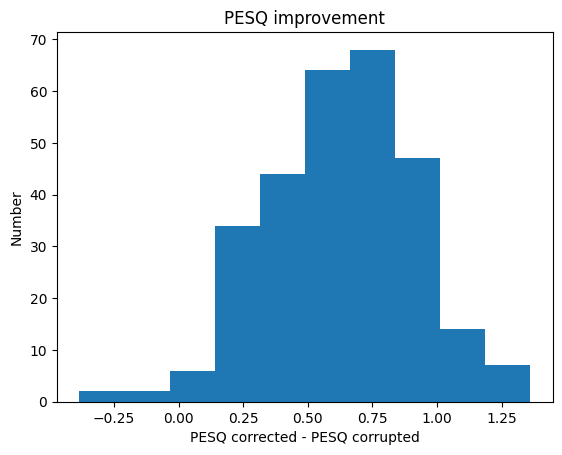

In [33]:
# Calculate and print the metrics:
def calculate_metrics(clean_signal, noisy_signal, enhanced_signal, sr=8000):
    """Calculates SNR, STOI, and PESQ metrics."""
    snr_noisy = calculate_snr(clean_signal, noisy_signal)
    snr_enhanced = calculate_snr(clean_signal, enhanced_signal)

    stoi_score = stoi(clean_signal, enhanced_signal, sr, extended=False)

    # Changed 'wb' to 'nb' for narrowband mode as sr=8000
    pesq_score = pesq(sr, clean_signal, enhanced_signal, 'nb')

    return snr_noisy, snr_enhanced, stoi_score, pesq_score

def calculate_snr(clean_signal, noisy_signal):
    """Calculates the Signal-to-Noise Ratio (SNR)."""
    # Ensure signals are NumPy arrays
    clean_signal = np.array(clean_signal)
    noisy_signal = np.array(noisy_signal)

    # Calculate the power of the clean signal
    clean_power = np.sum(clean_signal**2)

    # Calculate the power of the noise (noisy - clean)
    noise_power = np.sum((noisy_signal - clean_signal)**2)

    # Calculate SNR in dB
    snr = 10 * np.log10(clean_power / noise_power) if noise_power != 0 else float('inf') # handle division by zero

    return snr

# After processing your audio:
clean_wav = wav_clean_array[ind]  # Use actual clean audio data
wav_corrupt = wav_corrupt_array[ind]  # Use actual corrupted audio data
wav_correct = wav_correct_array[ind]  # Use actual corrected audio data
sr = 8000  # your sample rate

# Calculate and print the metrics:
snr_noisy, snr_enhanced, stoi_score, pesq_score = calculate_metrics(clean_wav, wav_corrupt, wav_correct, sr)

print(f"SNR (Noisy): {snr_noisy:.2f} dB")
print(f"SNR (Enhanced): {snr_enhanced:.2f} dB")
print(f"STOI: {stoi_score:.2f}")
print(f"PESQ: {pesq_score:.2f}")

# Visualization and saving results
os.system('rm -r val_results')
results_dir = 'val_results'
os.mkdir(results_dir)

fig = plt.figure()
plt.title('PESQ improvement')
plt.hist(pesq_diff)
plt.xlabel('PESQ corrected - PESQ corrupted')
plt.ylabel('Number')
fig.savefig(results_dir + '/pesq_hist', bbox_inches='tight')

ind = np.where(pesq_diff == pesq_diff.max())[0][0]
sf.write(results_dir + '/' + 'clean_best_pesq_improvement.wav', wav_clean_array[ind], sr)
sf.write(results_dir + '/' + 'corrupt_best_pesq_improvement.wav', wav_corrupt_array[ind], sr)
sf.write(results_dir + '/' + 'correct_best_pesq_improvement.wav', wav_correct_array[ind], sr)


0

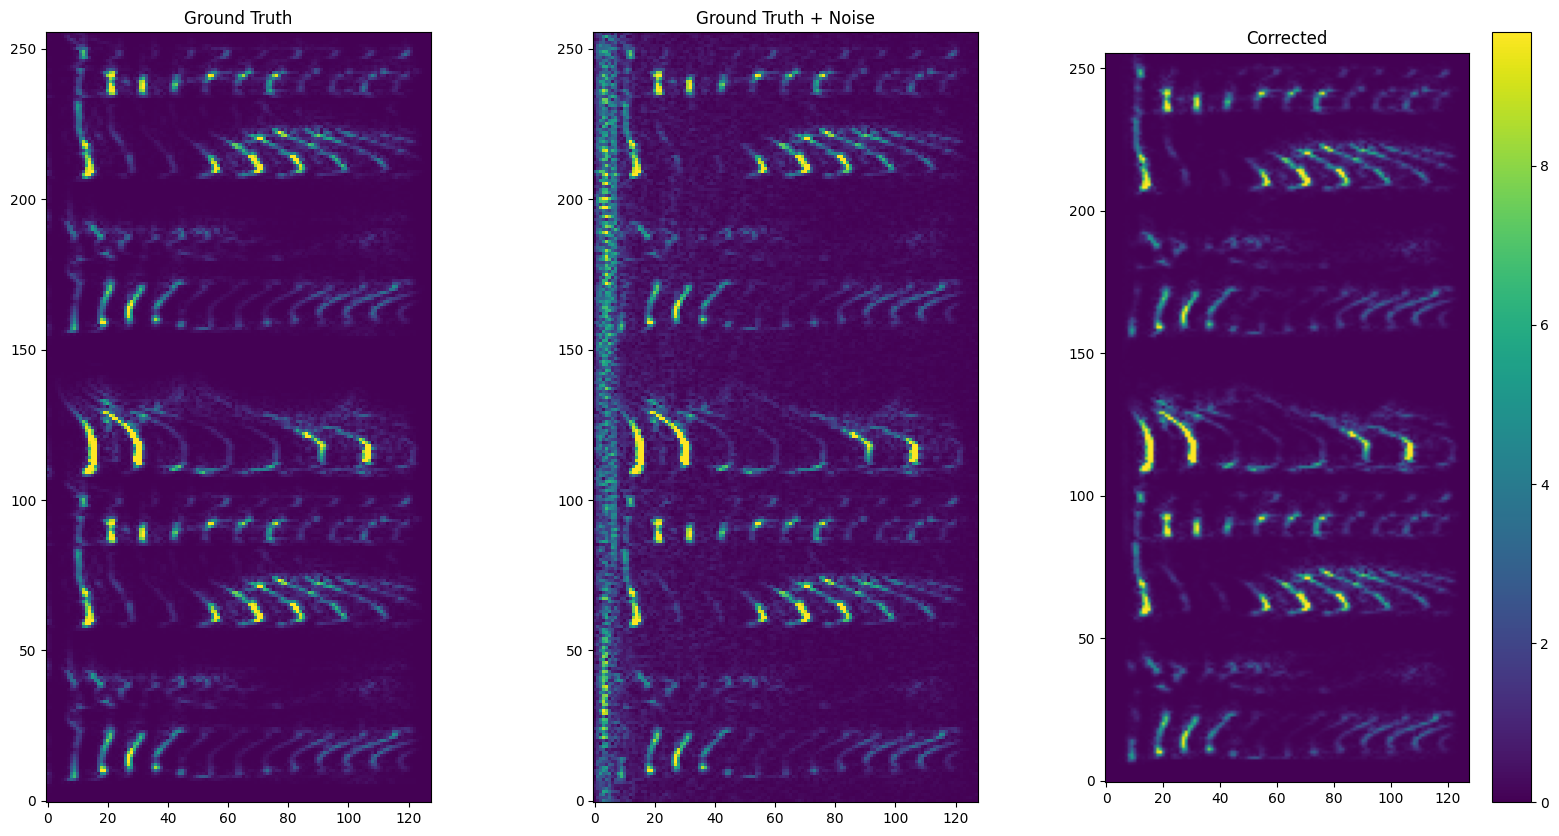

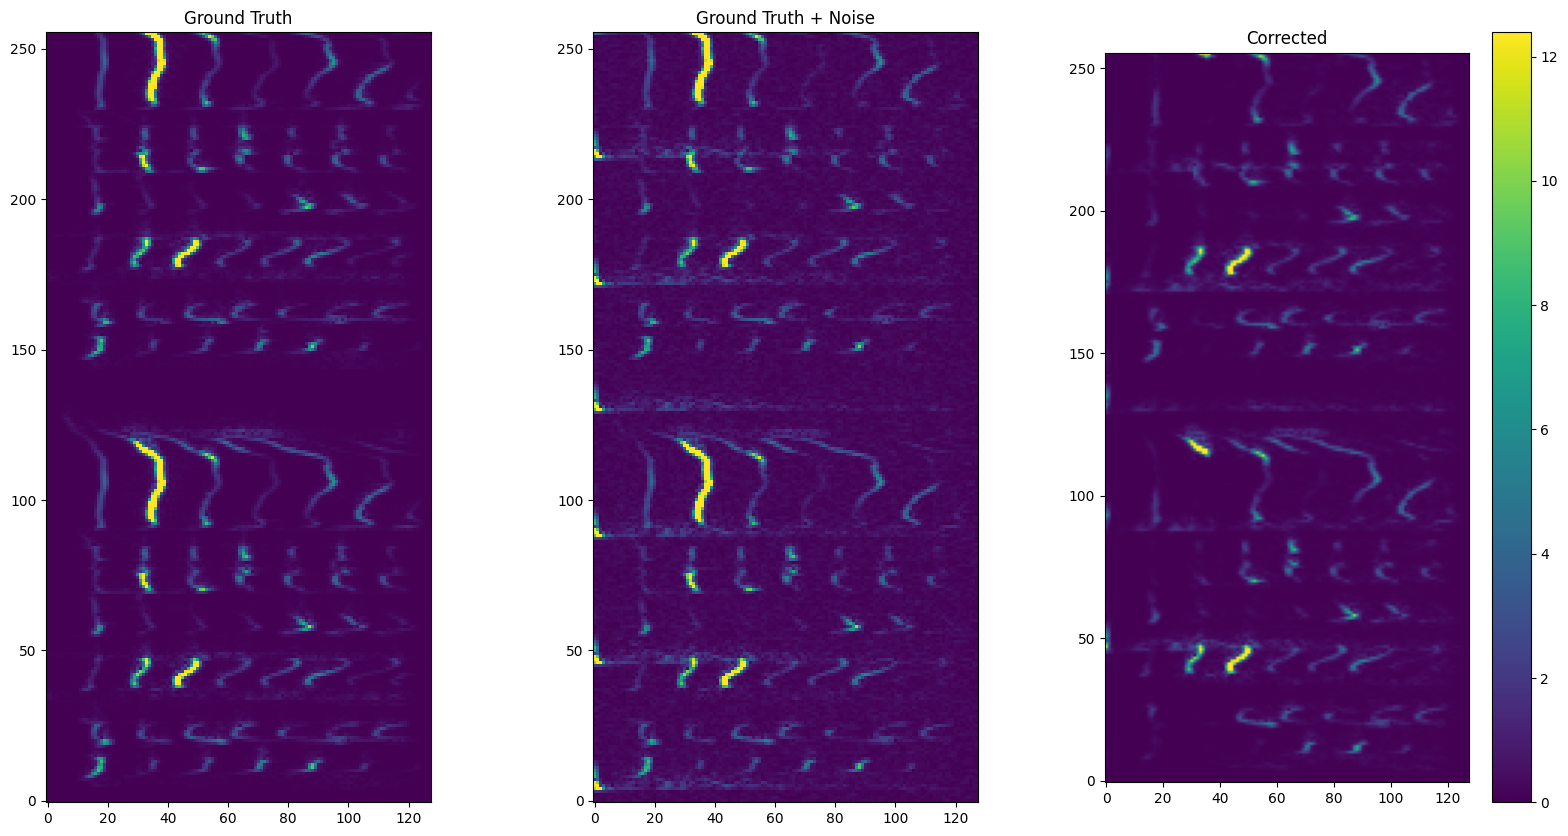

In [34]:

# Audio playback for best PESQ improvement
display(Audio(wav_clean_array[ind], rate=sr))
display(Audio(wav_corrupt_array[ind], rate=sr))
display(Audio(wav_correct_array[ind], rate=sr))

# Saving audio files for worst PESQ improvement
ind = np.where(pesq_diff == pesq_diff.min())[0][0]
sf.write(results_dir + '/' + 'clean_worst_pesq_improvement.wav', wav_clean_array[ind], sr)
sf.write(results_dir + '/' + 'corrupt_worst_pesq_improvement.wav', wav_corrupt_array[ind], sr)
sf.write(results_dir + '/' + 'correct_worst_pesq_improvement.wav', wav_correct_array[ind], sr)

# Audio playback for worst PESQ improvement
display(Audio(wav_clean_array[ind], rate=sr))
display(Audio(wav_corrupt_array[ind], rate=sr))
display(Audio(wav_correct_array[ind], rate=sr))

# Spectrogram visualization for best PESQ improvement
ind = np.where(pesq_diff == pesq_diff.max())[0][0]
fig, axes = plt.subplots(ncols=3, figsize=(20, 10))
vmax = spec_clean_array[ind].max() / 3
vmin = 0
plt.subplot(1, 3, 1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower', vmax=vmax, vmin=vmin)
plt.subplot(1, 3, 2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower', vmax=vmax, vmin=vmin)
plt.subplot(1, 3, 3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower', vmax=vmax, vmin=vmin)
plt.colorbar()
fig.savefig(results_dir + '/best_spec.png', bbox_inches='tight')

# Spectrogram visualization for worst PESQ improvement
ind = np.where(pesq_diff == pesq_diff.min())[0][0]
fig, axes = plt.subplots(ncols=3, figsize=(20, 10))
vmax = spec_clean_array[ind].max() / 3
vmin = 0
plt.subplot(1, 3, 1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower', vmax=vmax, vmin=vmin)
plt.subplot(1, 3, 2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower', vmax=vmax, vmin=vmin)
plt.subplot(1, 3, 3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower', vmax=vmax, vmin=vmin)
plt.colorbar()
fig.savefig(results_dir + '/worst_spec.png', bbox_inches='tight')

# Archiving results
os.system(f'tar -cvzf train_val_results.tar.gz {results_dir}')

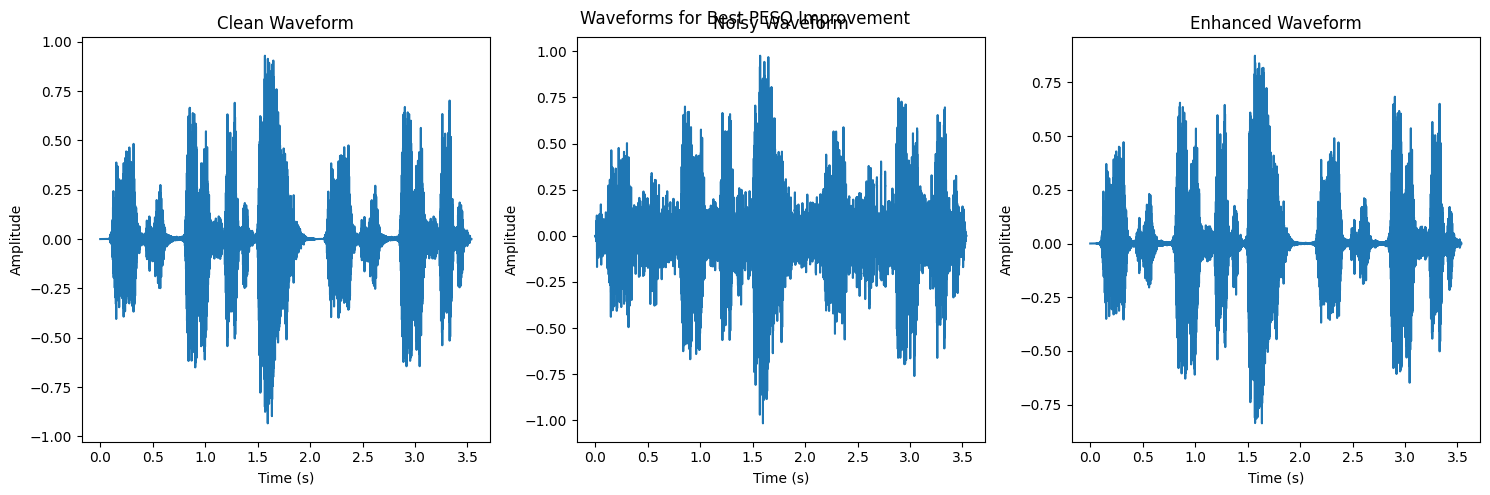

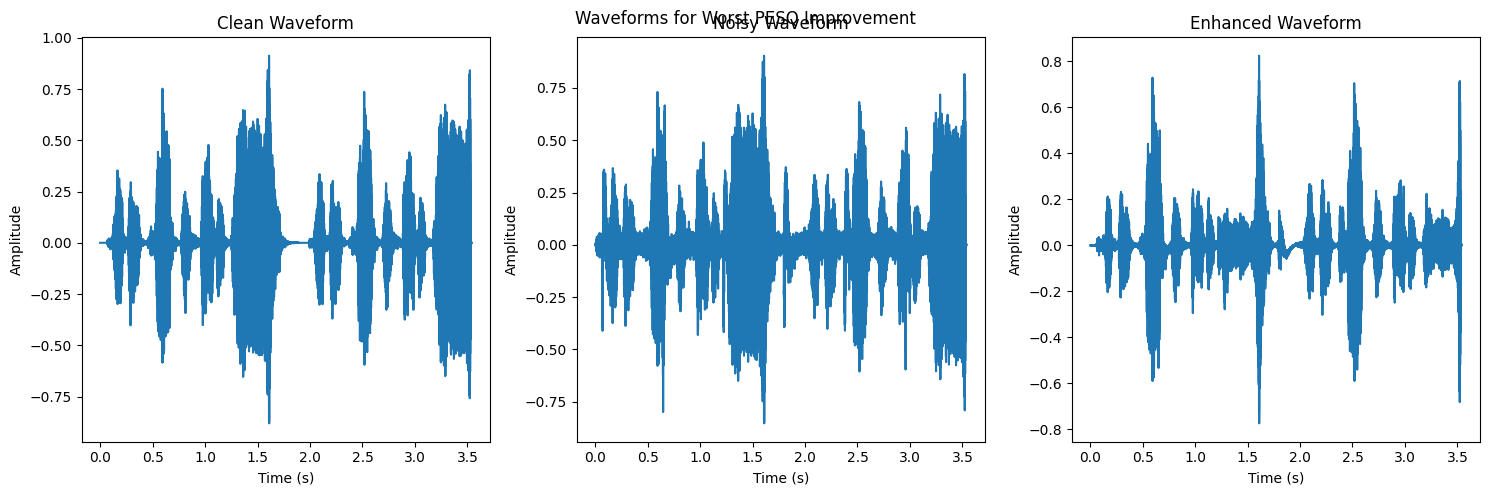

In [35]:
# Add this code after you have the wav_clean, wav_corrupt, and wav_correct arrays

def plot_waveforms(clean_wav, noisy_wav, enhanced_wav, sr, title="Audio Waveforms"):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(np.arange(len(clean_wav)) / sr, clean_wav)
    plt.title('Clean Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(1, 3, 2)
    plt.plot(np.arange(len(noisy_wav)) / sr, noisy_wav)
    plt.title('Noisy Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(1, 3, 3)
    plt.plot(np.arange(len(enhanced_wav)) / sr, enhanced_wav)
    plt.title('Enhanced Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

# Example usage after evaluation loop for a specific sample (e.g., the one with best PESQ)
ind_best = np.where(pesq_diff == pesq_diff.max())[0][0]
plot_waveforms(wav_clean_array[ind_best], wav_corrupt_array[ind_best], wav_correct_array[ind_best], sr, title="Waveforms for Best PESQ Improvement")

ind_worst = np.where(pesq_diff == pesq_diff.min())[0][0]
plot_waveforms(wav_clean_array[ind_worst], wav_corrupt_array[ind_worst], wav_correct_array[ind_worst], sr, title="Waveforms for Worst PESQ Improvement")

Evaluating for SNR: -5 dB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

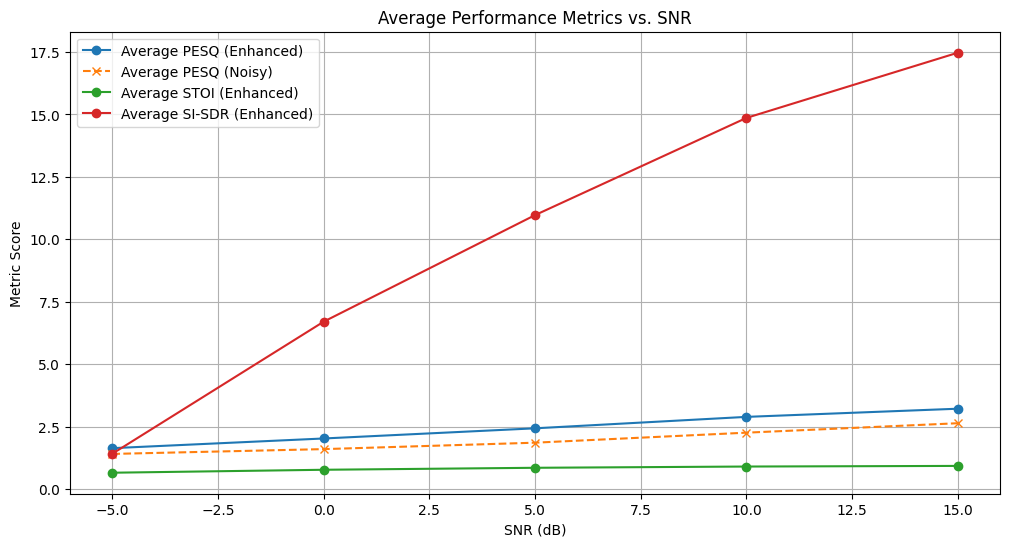

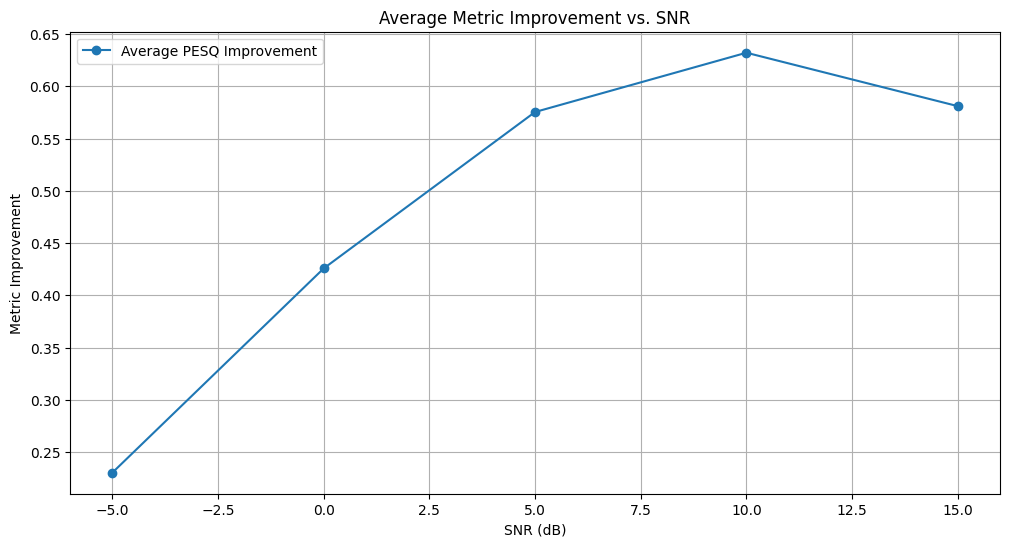


Example for SNR: -5 dB
Example audio files for SNR -5 dB saved to evaluation_results/audio_examples


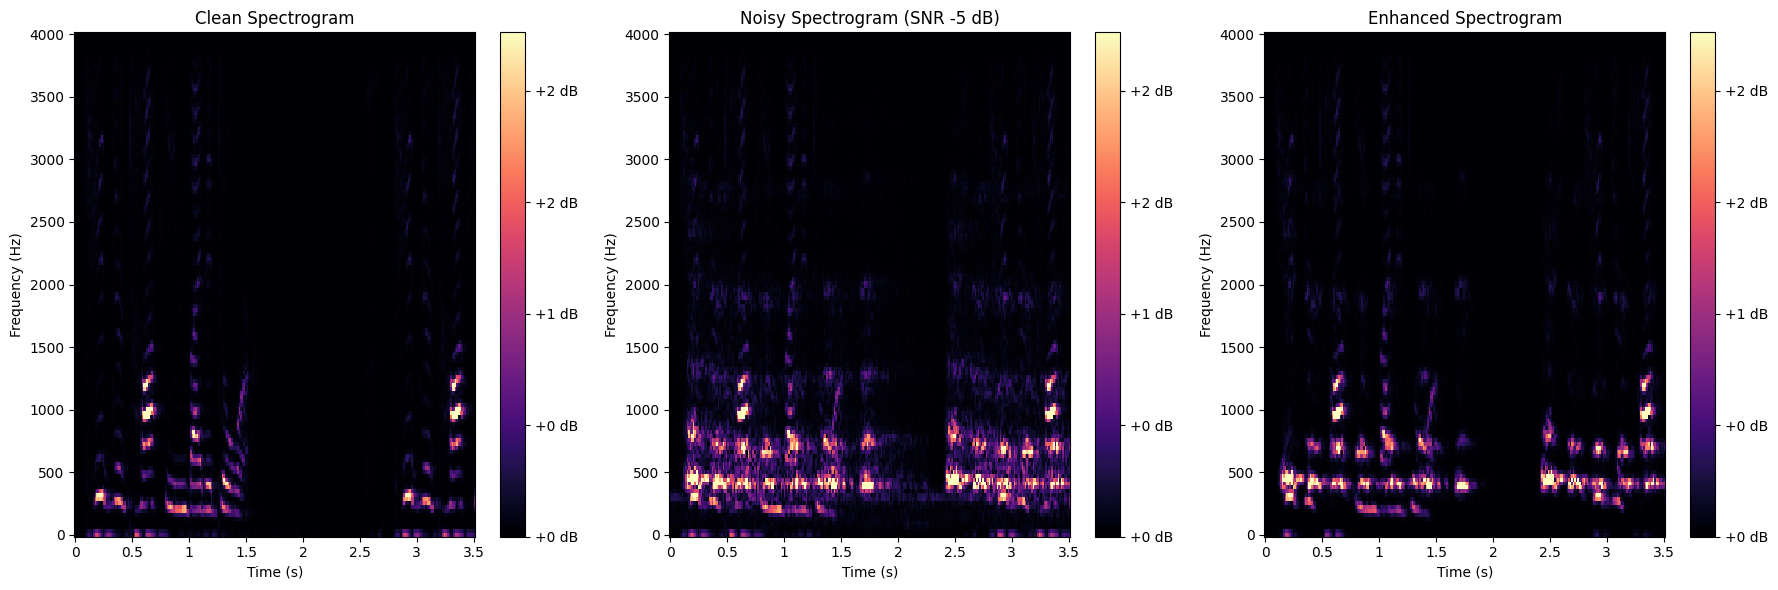


Example for SNR: 0 dB
Example audio files for SNR 0 dB saved to evaluation_results/audio_examples


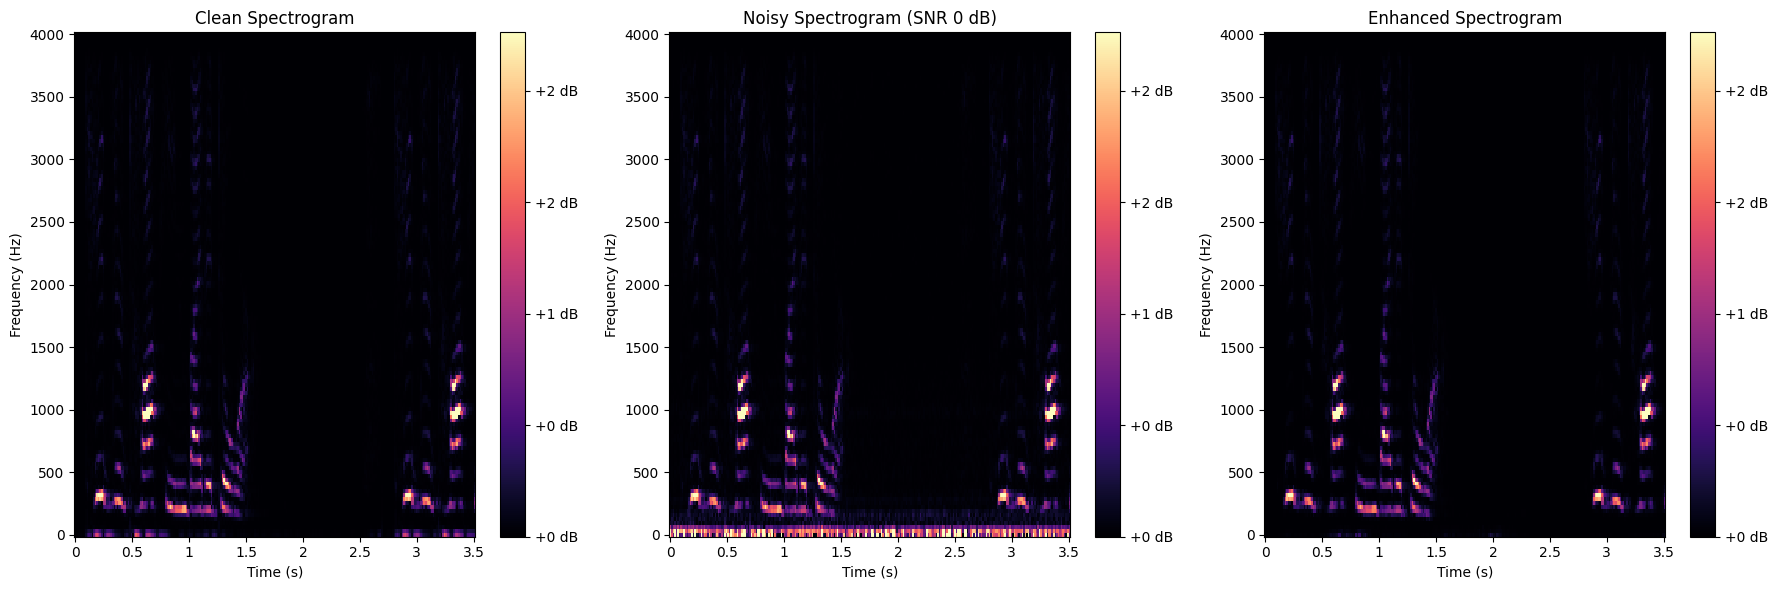


Example for SNR: 5 dB
Example audio files for SNR 5 dB saved to evaluation_results/audio_examples


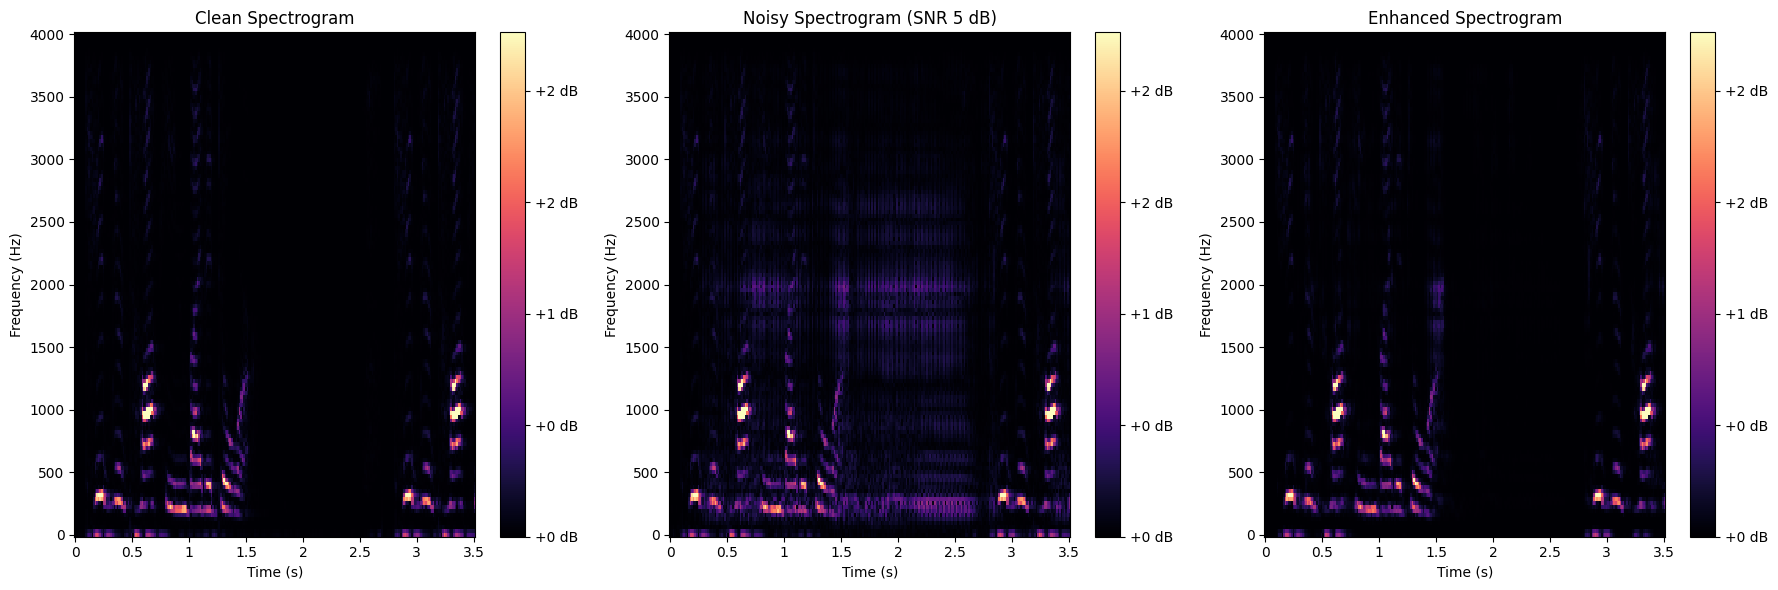


Example for SNR: 10 dB
Example audio files for SNR 10 dB saved to evaluation_results/audio_examples


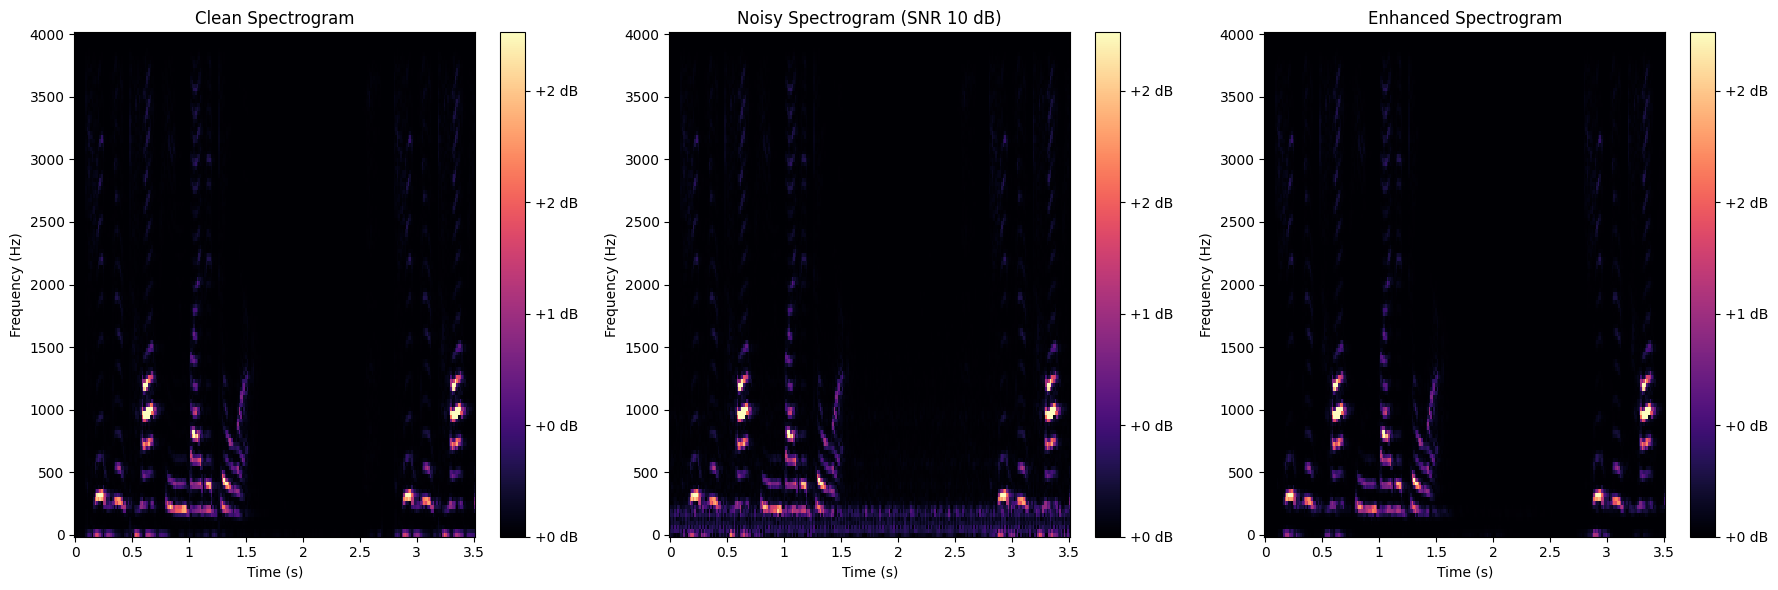


Example for SNR: 15 dB
Example audio files for SNR 15 dB saved to evaluation_results/audio_examples


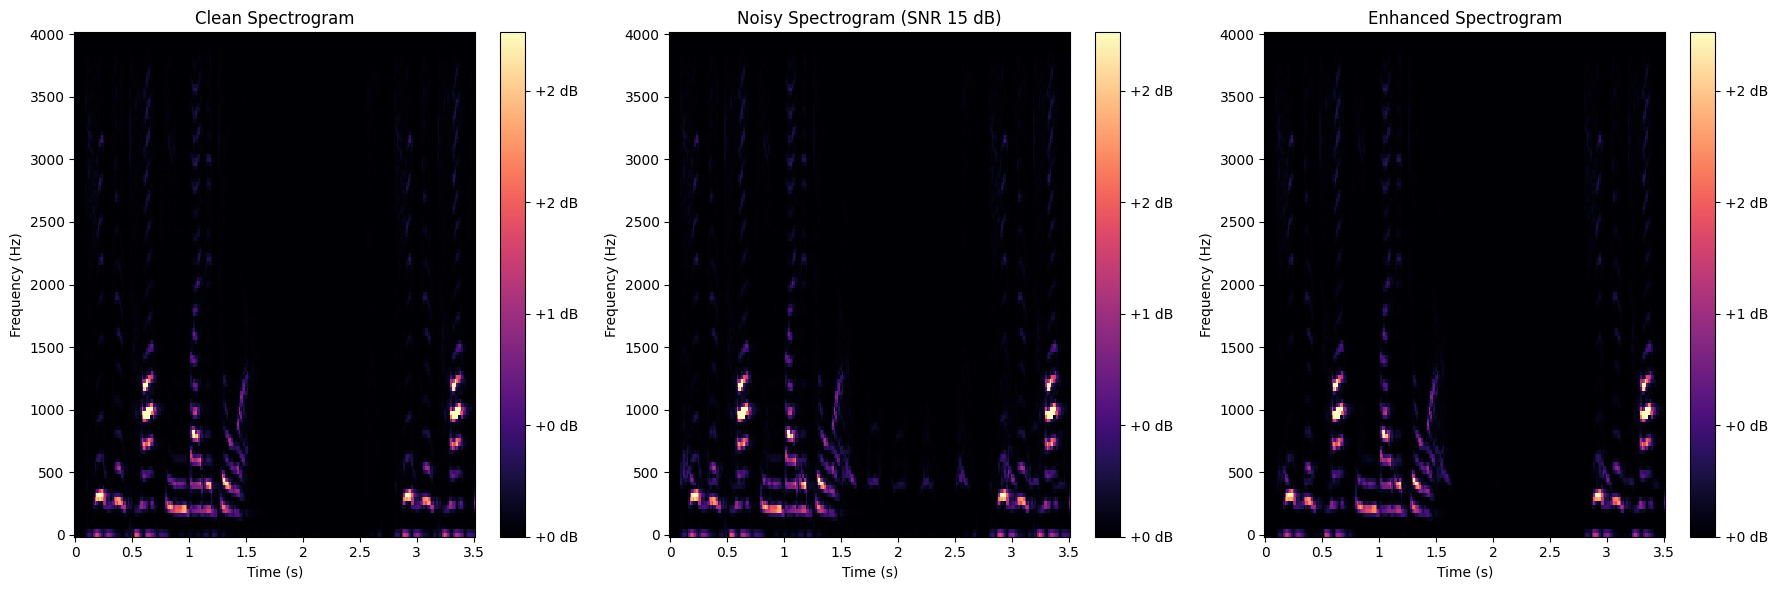

In [40]:
# Add these imports at the beginning of the file if not already present
import tensorflow as tf
import numpy as np
import librosa
from pystoi import stoi
from pesq import pesq
import soundfile as sf
import os
import matplotlib.pyplot as plt
import pandas as pd # Import pandas for saving results to CSV

# Assuming your existing functions like load_wav, preprocess_tf,
# convert_to_spectrogram, spectrogram_abs, add_white_noise_with_snr,
# add_urban_noise_with_snr, configure_dataset_with_snr are defined.
# Also assuming your model is defined and loaded.

# Function to calculate SI-SDR
def calculate_si_sdr(clean, estimate):
    """Calculates Scale-Invariant Source-to-Distortion Ratio (SI-SDR)."""
    # Ensure inputs are numpy arrays
    clean = np.array(clean)
    estimate = np.array(estimate)

    # Ensure same length (assuming padding/trimming is done elsewhere)
    min_len = min(len(clean), len(estimate))
    clean = clean[:min_len]
    estimate = estimate[:min_len]

    # Calculate projection of estimate onto clean
    s_target = np.sum(estimate * clean) * clean / np.sum(clean ** 2) if np.sum(clean ** 2) != 0 else clean * 0

    # Calculate error
    e_noise = estimate - s_target

    # Calculate SI-SDR
    # Handle potential division by zero by adding a small epsilon to the denominator
    epsilon = 1e-10
    # Use tf.reduce_sum for compatibility if inputs were tensors before conversion
    si_sdr = 10 * np.log10(np.sum(s_target ** 2) / (np.sum(e_noise ** 2) + epsilon))

    return si_sdr


@tf.function
def add_white_noise_with_snr(data, snr_db, sr=8000):
    """Adds white noise to a signal at a specified SNR."""
    # Calculate signal power using TensorFlow operations
    signal_power = tf.reduce_mean(data ** 2)

    if tf.equal(signal_power, 0.0):
        return data, data # Avoid division by zero if signal is silent

    # Calculate noise power based on desired SNR
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear

    # Generate white noise
    noise = tf.random.normal(shape=tf.shape(data), stddev=tf.sqrt(tf.cast(noise_power, tf.float32)))

    # Add noise to the signal
    noisy_data = data + noise

    return noisy_data, data

@tf.function
def add_urban_noise_with_snr(corr_data, data, snr_db, sr=sr):
    """Adds urban noise to a signal at a specified SNR."""
    # Calculate signal power using TensorFlow operations
    signal_power = tf.reduce_mean(corr_data ** 2)

    if tf.equal(signal_power, 0.0):
        return corr_data, data # Avoid division by zero

    # Calculate noise power based on desired SNR
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear

    # Select a random urban noise file
    noisefile = tf.gather(noisefiles, tf.random.uniform((), 0, len(noisefiles) - 1, dtype=tf.int32))
    noisefile = load_wav(noisefile)

    # Trim or pad noise file to match the length of the data
    noisefile = noisefile[:tf.shape(corr_data)[0]]
    zero_padding = tf.zeros([tf.shape(corr_data)[0]] - tf.shape(noisefile), dtype=tf.float32)
    noisefile = tf.concat([noisefile, zero_padding], 0)

    # Scale the noise file to the desired noise power using TensorFlow operations
    noisefile_power = tf.reduce_mean(noisefile ** 2)
    # Handle potential division by zero within the TensorFlow graph
    noisefile = tf.cond(
        tf.math.not_equal(noisefile_power, 0.0),
        lambda: noisefile * tf.sqrt(tf.cast(noise_power / noisefile_power, tf.float32)),
        lambda: noisefile # If noise power is zero, return the original noisefile
    )

    # Add noise to the signal
    mixed = corr_data + noisefile

    return mixed, data


# Modify configure_dataset to include SNR control and return complex spectrograms for evaluation
def configure_dataset_with_snr_eval(files, snr_db):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_wav, num_parallel_calls=tf.data.AUTOTUNE)

    # Add noise with specified SNR - returns noisy_wav, clean_wav
    dataset = dataset.map(lambda x: add_urban_noise_with_snr(x, x, snr_db), num_parallel_calls=tf.data.AUTOTUNE)

    # Convert to complex spectrograms - returns corr_spec (complex), clean_spec (complex)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)

    # We don't apply spectrogram_abs, augment, or expand_dims for evaluation here.
    # The model expects magnitude spectrogram with channel dimension, so we'll handle that in the loop.

    # return clean_spec (complex), corr_spec (complex)
    return dataset.map(lambda corr_spec, clean_spec: (clean_spec, corr_spec))


# Define the SNR levels you want to evaluate
snr_levels = [-5, 0, 5, 10, 15]

# Initialize dictionaries to store results and visualization data
pesq_results = {}
stoi_results = {}
si_sdr_results = {}
pesq_noisy_results = {} # To store PESQ of noisy signal

# Dictionaries to store example data for visualization and audio saving
example_data = {
    'clean_wav': {},
    'noisy_wav': {},
    'enhanced_wav': {},
    'clean_spec': {},
    'noisy_spec': {},
    'enhanced_spec': {}
}

# Create results directory if it doesn't exist
results_dir = 'evaluation_results'
os.makedirs(results_dir, exist_ok=True)
audio_results_dir = os.path.join(results_dir, 'audio_examples')
os.makedirs(audio_results_dir, exist_ok=True)

for snr_db in snr_levels:
    print(f"Evaluating for SNR: {snr_db} dB")
    # Create a test dataset for the current SNR level
    # configure_dataset_with_snr_eval returns clean_spec (complex), corr_spec (complex)
    test_dataset_snr = configure_dataset_with_snr_eval(val_files, snr_db)

    pesq_scores = []
    stoi_scores = []
    si_sdr_scores = []
    pesq_noisy_scores = [] # List to store PESQ of noisy signal

    # Iterate through the dataset. Use batch(1) to process one sample at a time
    # The dataset now returns (clean_spec (complex), corr_spec (complex))
    for batch_idx, (clean_spec_batch, corr_spec_batch) in enumerate(test_dataset_snr.batch(1).as_numpy_iterator()):
        # Remove batch dimension
        clean_spec = clean_spec_batch[0]
        corr_spec = corr_spec_batch[0]

        # Get the original phase from the noisy spectrogram
        corr_phase = np.angle(corr_spec)

        # Get magnitude for model prediction and add channel dimension
        corr_amp = np.abs(corr_spec)
        # Add batch dimension and channel dimension for prediction
        # Model expects input shape (batch_size, frames, fft_bins, channels)
        input_spectrogram = np.expand_dims(np.expand_dims(corr_amp, 0), -1)
        corrected_amp = model.predict(input_spectrogram)

        # Remove batch dimension and channel dimension after prediction
        # The output from model.predict has shape (batch_size, frames, fft_bins, 1)
        corrected_amp = corrected_amp[0, :, :, 0]

        # Combine predicted magnitude with original phase to get complex spectrogram
        corrected_spec = corrected_amp * np.exp(1j * corr_phase)

        # Convert spectrograms back to audio
        try:
            # Ensure shapes are correct for inverse_stft: (..., frames, fft_bins)
            corr_wav = tf.signal.inverse_stft(corr_spec, frame_length=frame_length, fft_length=n_fft, frame_step=frame_step).numpy() # Don't squeeze here
            clean_wav = tf.signal.inverse_stft(clean_spec, frame_length=frame_length, fft_length=n_fft, frame_step=frame_step).numpy() # Don't squeeze here
            corrected_wav = tf.signal.inverse_stft(corrected_spec, frame_length=frame_length, fft_length=n_fft, frame_step=frame_step).numpy() # Don't squeeze here

            # Ensure audio signals have the same length before calculating metrics
            min_len = min(clean_wav.shape[-1], corr_wav.shape[-1], corrected_wav.shape[-1])
            clean_wav = clean_wav[..., :min_len] # Trim along the time dimension
            corr_wav = corr_wav[..., :min_len]
            corrected_wav = corrected_wav[..., :min_len]

            # Squeeze the channel dimension if present after inverse_stft
            clean_wav = clean_wav.squeeze()
            corr_wav = corr_wav.squeeze()
            corrected_wav = corrected_wav.squeeze()


            # Calculate metrics
            # PESQ and STOI require 1D numpy arrays
            try:
                # PESQ of noisy signal
                pesq_noisy_score = pesq(sr, clean_wav, corr_wav, 'nb')
                pesq_noisy_scores.append(pesq_noisy_score)

                # PESQ of enhanced signal
                pesq_score = pesq(sr, clean_wav, corrected_wav, 'nb')
                pesq_scores.append(pesq_score)
            except Exception as e:
                print(f"Error calculating PESQ for SNR {snr_db}, sample {batch_idx}: {e}")

            try:
                stoi_score = stoi(clean_wav, corrected_wav, sr, extended=False)
                stoi_scores.append(stoi_score)
            except Exception as e:
                print(f"Error calculating STOI for SNR {snr_db}, sample {batch_idx}: {e}")

            try:
                si_sdr_score = calculate_si_sdr(clean_wav, corrected_wav)
                si_sdr_scores.append(si_sdr_score)
            except Exception as e:
                 print(f"Error calculating SI-SDR for SNR {snr_db}, sample {batch_idx}: {e}")
                 si_sdr_scores.append(np.nan) # Append NaN or a placeholder

            # Store example data for visualization and audio saving (e.g., for the first sample of each SNR)
            if batch_idx == 0: # Store only the first sample of each SNR level
                 example_data['clean_wav'][snr_db] = clean_wav
                 example_data['noisy_wav'][snr_db] = corr_wav
                 example_data['enhanced_wav'][snr_db] = corrected_wav
                 example_data['clean_spec'][snr_db] = np.abs(clean_spec)
                 example_data['noisy_spec'][snr_db] = np.abs(corr_spec)
                 example_data['enhanced_spec'][snr_db] = corrected_amp

        except Exception as e:
            print(f"Error processing sample for SNR {snr_db}, batch {batch_idx}: {e}")
            continue # Skip to the next batch if there's an error converting back to audio


    # Store the average scores for the current SNR level
    pesq_results[snr_db] = np.mean(pesq_scores) if pesq_scores else np.nan
    stoi_results[snr_db] = np.mean(stoi_scores) if stoi_scores else np.nan
    si_sdr_results[snr_db] = np.nanmean(si_sdr_scores) if si_sdr_scores else np.nan # Use nanmean to handle NaNs
    pesq_noisy_results[snr_db] = np.mean(pesq_noisy_scores) if pesq_noisy_scores else np.nan # Store average noisy PESQ

# --- Save Metrics to CSV ---
metrics_df = pd.DataFrame({
    'SNR_dB': snr_levels,
    'Average_PESQ_Noisy': [pesq_noisy_results.get(snr, np.nan) for snr in snr_levels],
    'Average_PESQ_Enhanced': [pesq_results.get(snr, np.nan) for snr in snr_levels],
    'Average_STOI_Enhanced': [stoi_results.get(snr, np.nan) for snr in snr_levels],
    'Average_SI_SDR_Enhanced': [si_sdr_results.get(snr, np.nan) for snr in snr_levels]
})
metrics_df.to_csv(os.path.join(results_dir, 'average_metrics_by_snr.csv'), index=False)
print(f"\nAverage metrics saved to {os.path.join(results_dir, 'average_metrics_by_snr.csv')}")

# Print the results
print("\nPerformance Metrics Across Different SNR Levels:")
print("SNR (dB) | Avg PESQ (Noisy) | Avg PESQ (Enhanced) | Avg STOI (Enhanced) | Avg SI-SDR (Enhanced)")
print("------------------------------------------------------------------------")
for snr_db in snr_levels:
    print(f"{snr_db:<8} | {pesq_noisy_results.get(snr_db, np.nan):<16.2f} | {pesq_results.get(snr_db, np.nan):<19.2f} | {stoi_results.get(snr_db, np.nan):<19.2f} | {si_sdr_results.get(snr_db, np.nan):<20.2f}")


# --- Visualization ---

# Plot average metrics vs. SNR
plt.figure(figsize=(12, 6))
plt.plot(snr_levels, [pesq_results.get(snr, np.nan) for snr in snr_levels], marker='o', label='Average PESQ (Enhanced)')
plt.plot(snr_levels, [pesq_noisy_results.get(snr, np.nan) for snr in snr_levels], marker='x', linestyle='--', label='Average PESQ (Noisy)') # Add noisy PESQ
plt.plot(snr_levels, [stoi_results.get(snr, np.nan) for snr in snr_levels], marker='o', label='Average STOI (Enhanced)')
plt.plot(snr_levels, [si_sdr_results.get(snr, np.nan) for snr in snr_levels], marker='o', label='Average SI-SDR (Enhanced)')
plt.xlabel('SNR (dB)')
plt.ylabel('Metric Score')
plt.title('Average Performance Metrics vs. SNR')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'average_metrics_vs_snr.png'), bbox_inches='tight')
plt.show()

# Plot average metric improvement vs. SNR
plt.figure(figsize=(12, 6))
pesq_improvement = [pesq_results.get(snr, np.nan) - pesq_noisy_results.get(snr, np.nan) for snr in snr_levels]
plt.plot(snr_levels, pesq_improvement, marker='o', label='Average PESQ Improvement')
# You could potentially calculate and plot STOI/SI-SDR improvement if you calculated noisy STOI/SI-SDR
plt.xlabel('SNR (dB)')
plt.ylabel('Metric Improvement')
plt.title('Average Metric Improvement vs. SNR')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'average_metric_improvement_vs_snr.png'), bbox_inches='tight')
plt.show()


# Visualize example spectrograms per SNR level and save audio
for snr_db in snr_levels:
    if snr_db in example_data['clean_wav']: # Check if we stored an example for this SNR
        print(f"\nExample for SNR: {snr_db} dB")
        clean_wav_ex = example_data['clean_wav'][snr_db]
        noisy_wav_ex = example_data['noisy_wav'][snr_db]
        enhanced_wav_ex = example_data['enhanced_wav'][snr_db]
        clean_spec_ex = example_data['clean_spec'][snr_db]
        noisy_spec_ex = example_data['noisy_spec'][snr_db]
        enhanced_spec_ex = example_data['enhanced_spec'][snr_db]


        # Save example audio files
        sf.write(os.path.join(audio_results_dir, f'clean_snr_{snr_db}dB.wav'), clean_wav_ex, sr)
        sf.write(os.path.join(audio_results_dir, f'noisy_snr_{snr_db}dB.wav'), noisy_wav_ex, sr)
        sf.write(os.path.join(audio_results_dir, f'enhanced_snr_{snr_db}dB.wav'), enhanced_wav_ex, sr)
        print(f"Example audio files for SNR {snr_db} dB saved to {audio_results_dir}")

        # Plot spectrograms
        fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
        # Set a common color scale based on the max value of the clean spectrogram
        vmax = np.max(clean_spec_ex) / 3
        vmin = 0
        # Define hop length for librosa plotting
        hop_length = frame_step # Use the same frame_step as in STFT

        ax = axes[0]
        # Use librosa.display.specshow for better spectrogram visualization
        img = librosa.display.specshow(clean_spec_ex.T, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz', ax=ax, vmax=vmax, vmin=vmin)
        ax.set_title('Clean Spectrogram')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        # Add colorbar specific to this axes
        fig.colorbar(img, ax=ax, format='%+2.0f dB')


        ax = axes[1]
        # Use librosa.display.specshow for noisy spectrogram
        img = librosa.display.specshow(noisy_spec_ex.T, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz', ax=ax, vmax=vmax, vmin=vmin)
        ax.set_title(f'Noisy Spectrogram (SNR {snr_db} dB)')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        # Add colorbar specific to this axes
        fig.colorbar(img, ax=ax, format='%+2.0f dB')


        ax = axes[2]
        # Use librosa.display.specshow for enhanced spectrogram
        img = librosa.display.specshow(enhanced_spec_ex.T, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz', ax=ax, vmax=vmax, vmin=vmin)
        ax.set_title('Enhanced Spectrogram')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        # Add colorbar specific to this axes
        fig.colorbar(img, ax=ax, format='%+2.0f dB')


        # fig.colorbar(img, ax=axes.ravel().tolist()) # Remove this line
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f'spectrograms_snr_{snr_db}.png'), bbox_inches='tight')
        plt.show()

# You might want to add archiving the 'evaluation_results' directory as well
# os.system(f'tar -cvzf evaluation_results.tar.gz {results_dir}')

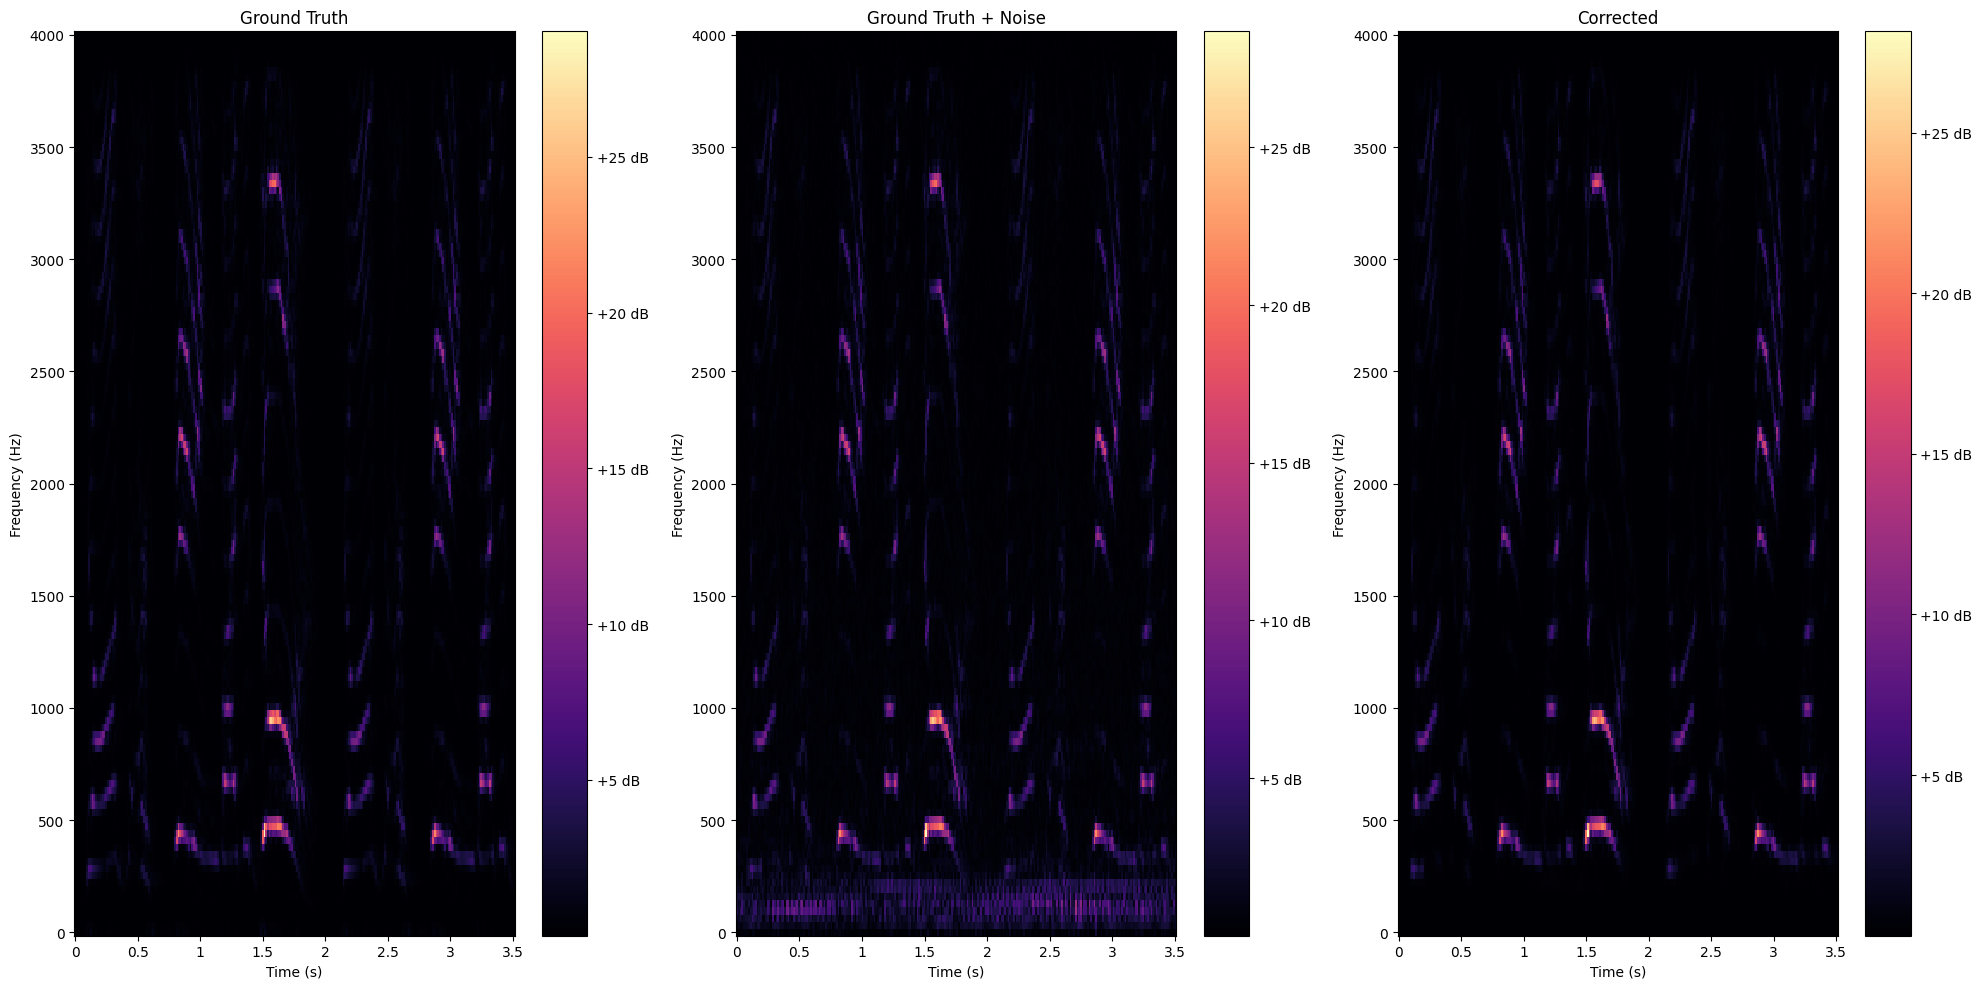

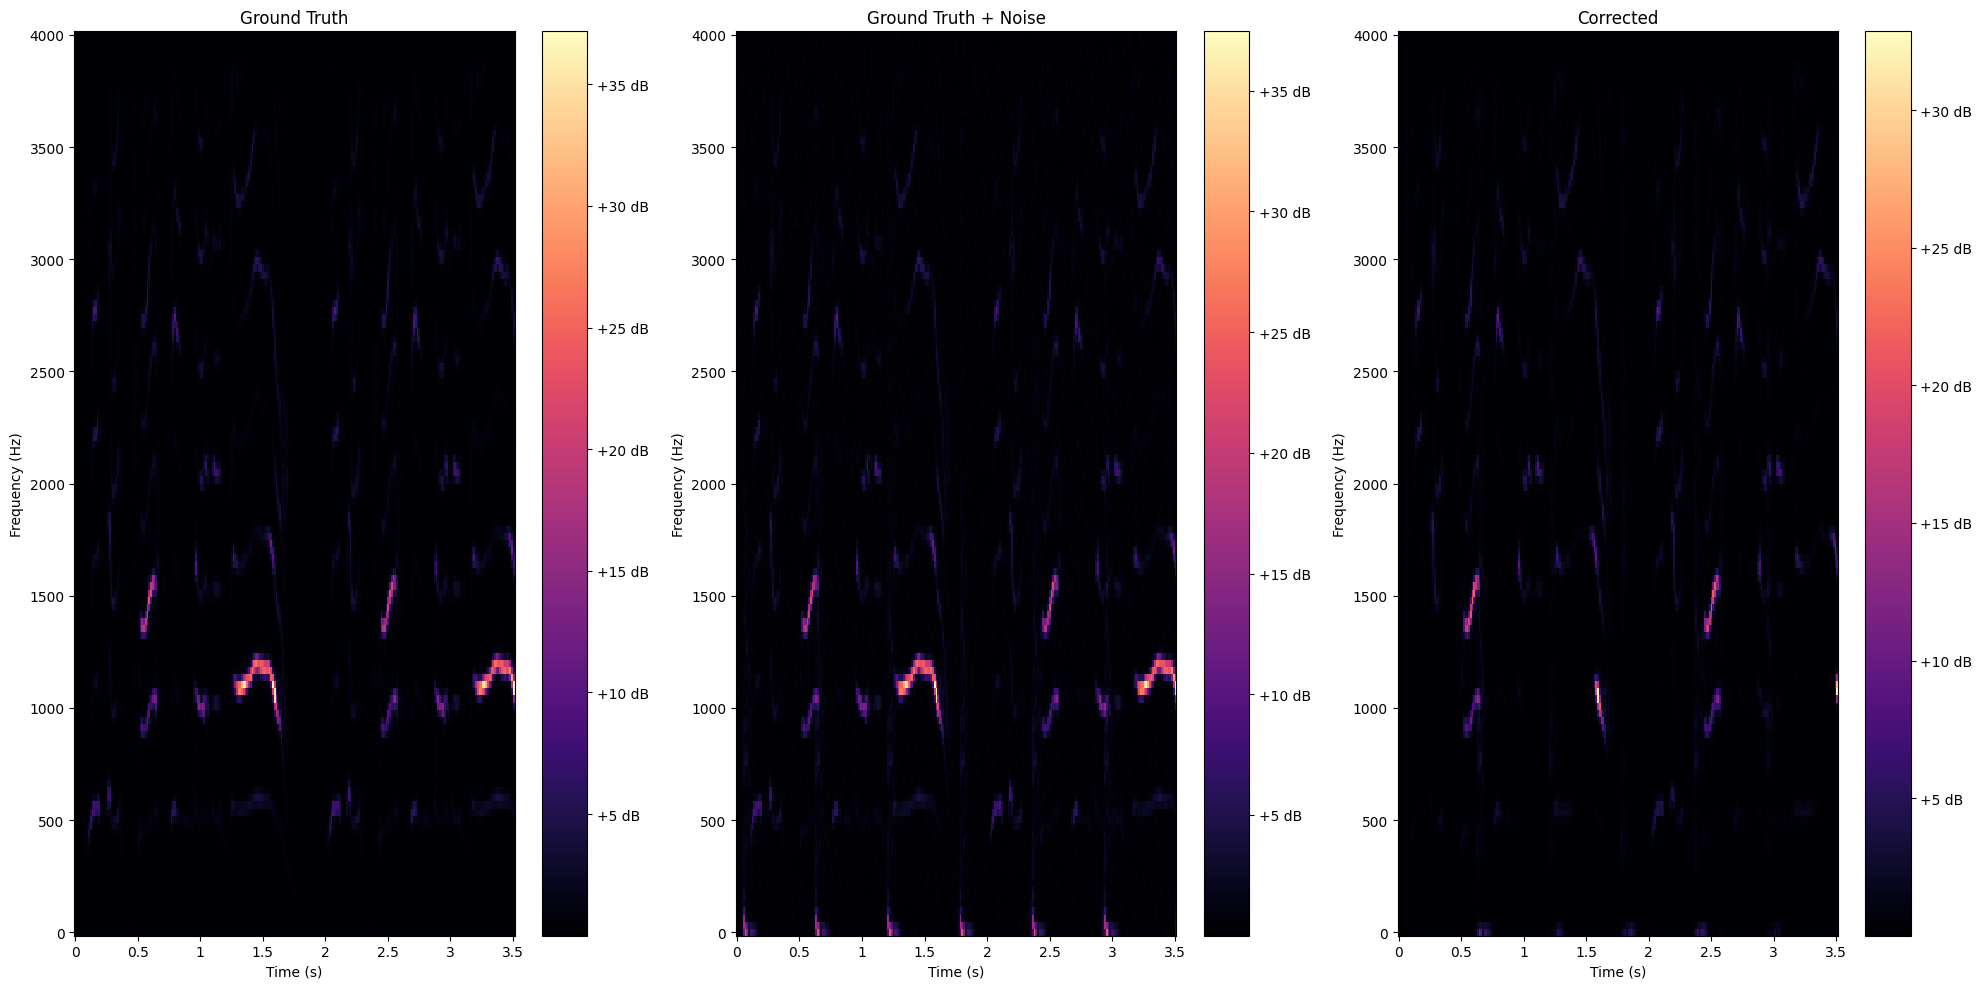

0

In [42]:
# Spectrogram visualization for best PESQ improvement
ind = np.where(pesq_diff == pesq_diff.max())[0][0]
fig, axes = plt.subplots(ncols=3, figsize=(20, 10))

# Calculate hop length in seconds (not directly used in specshow but good for reference)
# hop_length_sec = frame_step / sr # This line is not necessary here

# Plot Clean Spectrogram
plt.subplot(1, 3, 1) # Use plt.subplot to make it the active subplot
plt.title('Ground Truth')
# Transpose the spectrogram data so time is on the x-axis and frequency on the y-axis
# Store the mappable object returned by specshow
img_clean = librosa.display.specshow(spec_clean_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[0])
# Pass the mappable object and the axes to colorbar
fig.colorbar(img_clean, ax=axes[0], format='%+2.0f dB')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Frequency (Hz)')


# Plot Corrupted Spectrogram
plt.subplot(1, 3, 2) # Use plt.subplot to make it the active subplot
plt.title('Ground Truth + Noise')
# Transpose and plot corrupted spectrogram
img_corrupt = librosa.display.specshow(spec_corrupt_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[1])
# Pass the mappable object and the axes to colorbar
fig.colorbar(img_corrupt, ax=axes[1], format='%+2.0f dB')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')

# Plot Corrected Spectrogram
plt.subplot(1, 3, 3) # Use plt.subplot to make it the active subplot
plt.title('Corrected')
# Transpose and plot corrected spectrogram
img_correct = librosa.display.specshow(spec_correct_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[2])
# Pass the mappable object and the axes to colorbar
fig.colorbar(img_correct, ax=axes[2], format='%+2.0f dB')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Frequency (Hz)')

# Adjust layout and save
plt.tight_layout()
fig.savefig(results_dir + '/best_spec.png', bbox_inches='tight')
plt.show() # Display the plot

# Spectrogram visualization for worst PESQ improvement
ind = np.where(pesq_diff == pesq_diff.min())[0][0]
fig, axes = plt.subplots(ncols=3, figsize=(20, 10))

# Plot Clean Spectrogram (Worst)
plt.subplot(1, 3, 1) # Use plt.subplot to make it the active subplot
plt.title('Ground Truth')
# Transpose and plot clean spectrogram for worst case
img_clean_worst = librosa.display.specshow(spec_clean_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[0])
# Pass the mappable object and the axes to colorbar
fig.colorbar(img_clean_worst, ax=axes[0], format='%+2.0f dB')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Frequency (Hz)')

# Plot Corrupted Spectrogram (Worst)
plt.subplot(1, 3, 2) # Use plt.subplot to make it the active subplot
plt.title('Ground Truth + Noise')
# Transpose and plot corrupted spectrogram for worst case
img_corrupt_worst = librosa.display.specshow(spec_corrupt_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[1])
# Pass the mappable object and the axes to colorbar
fig.colorbar(img_corrupt_worst, ax=axes[1], format='%+2.0f dB')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')

# Plot Corrected Spectrogram (Worst)
plt.subplot(1, 3, 3) # Use plt.subplot to make it the active subplot
plt.title('Corrected')
# Transpose and plot corrected spectrogram for worst case
img_correct_worst = librosa.display.specshow(spec_correct_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[2])
# Pass the mappable object and the axes to colorbar
fig.colorbar(img_correct_worst, ax=axes[2], format='%+2.0f dB')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Frequency (Hz)')

# Adjust layout and save
plt.tight_layout()
fig.savefig(results_dir + '/worst_spec.png', bbox_inches='tight')
plt.show() # Display the plot


# Archiving results (keep this as is)
os.system(f'tar -cvzf train_val_results.tar.gz {results_dir}')

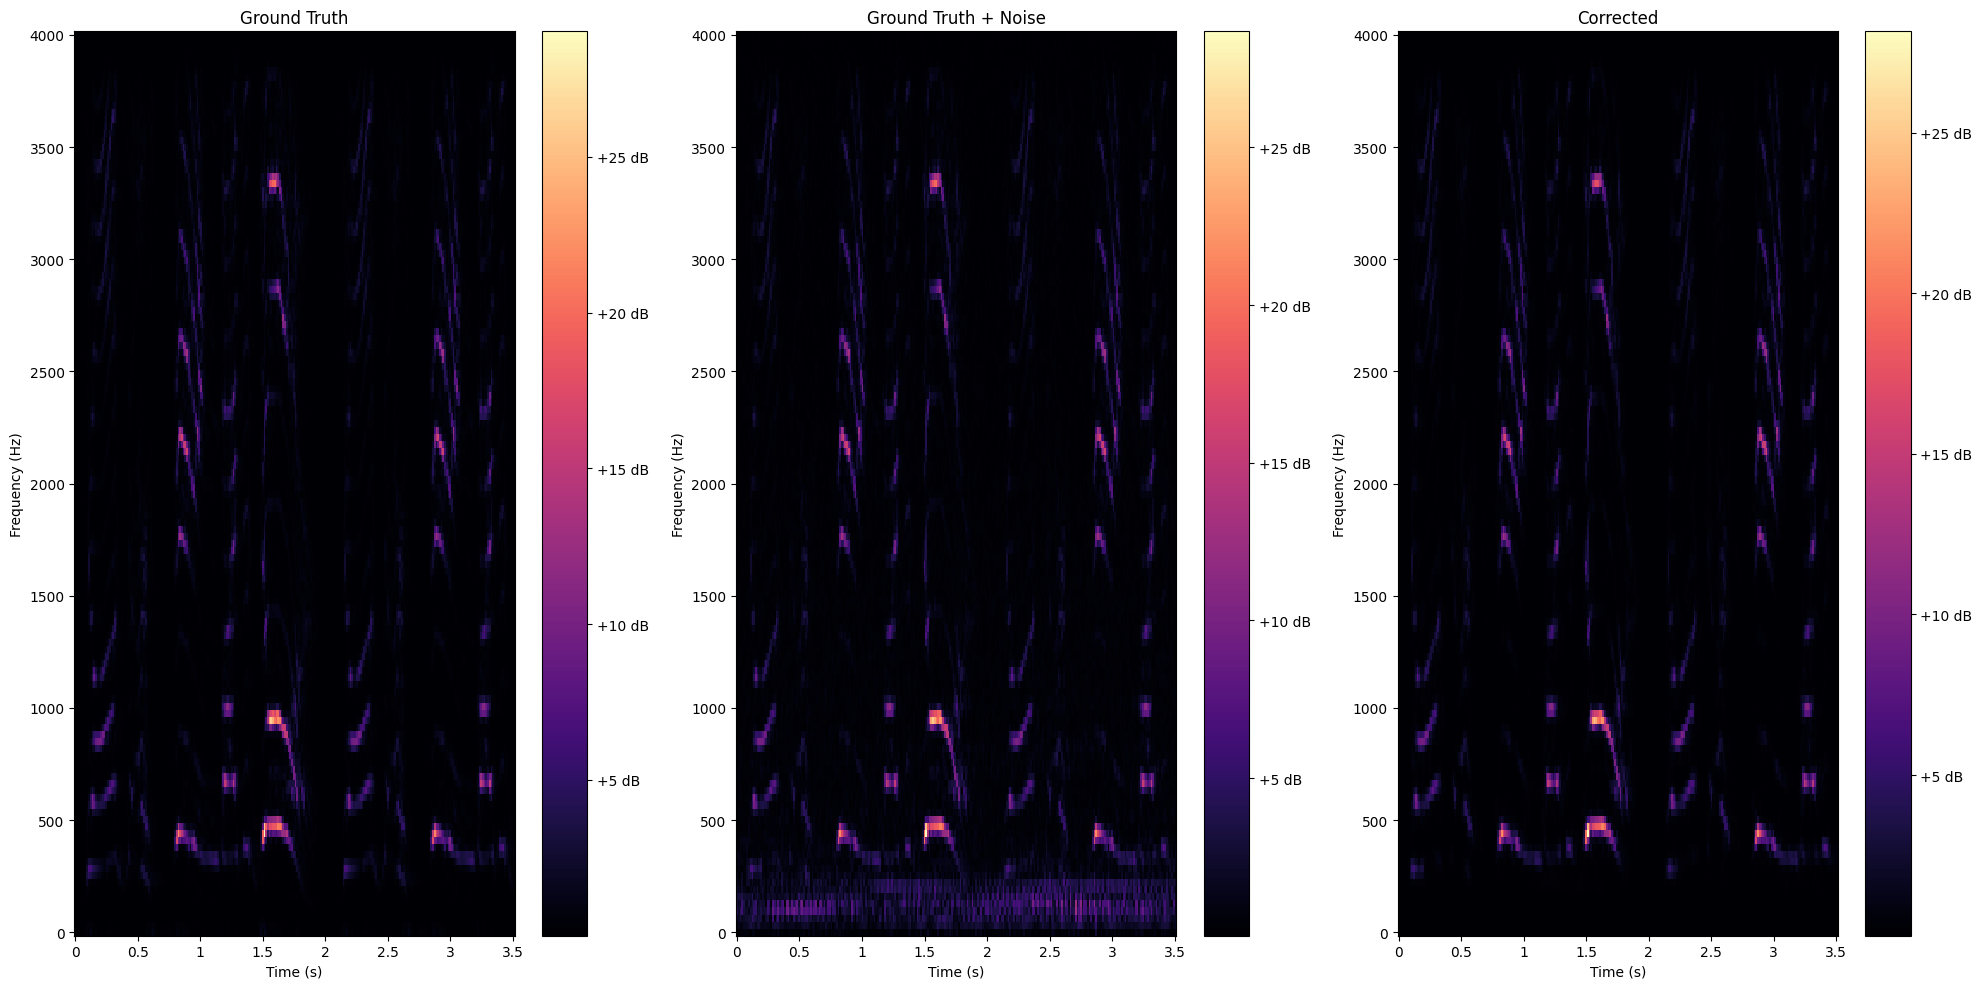

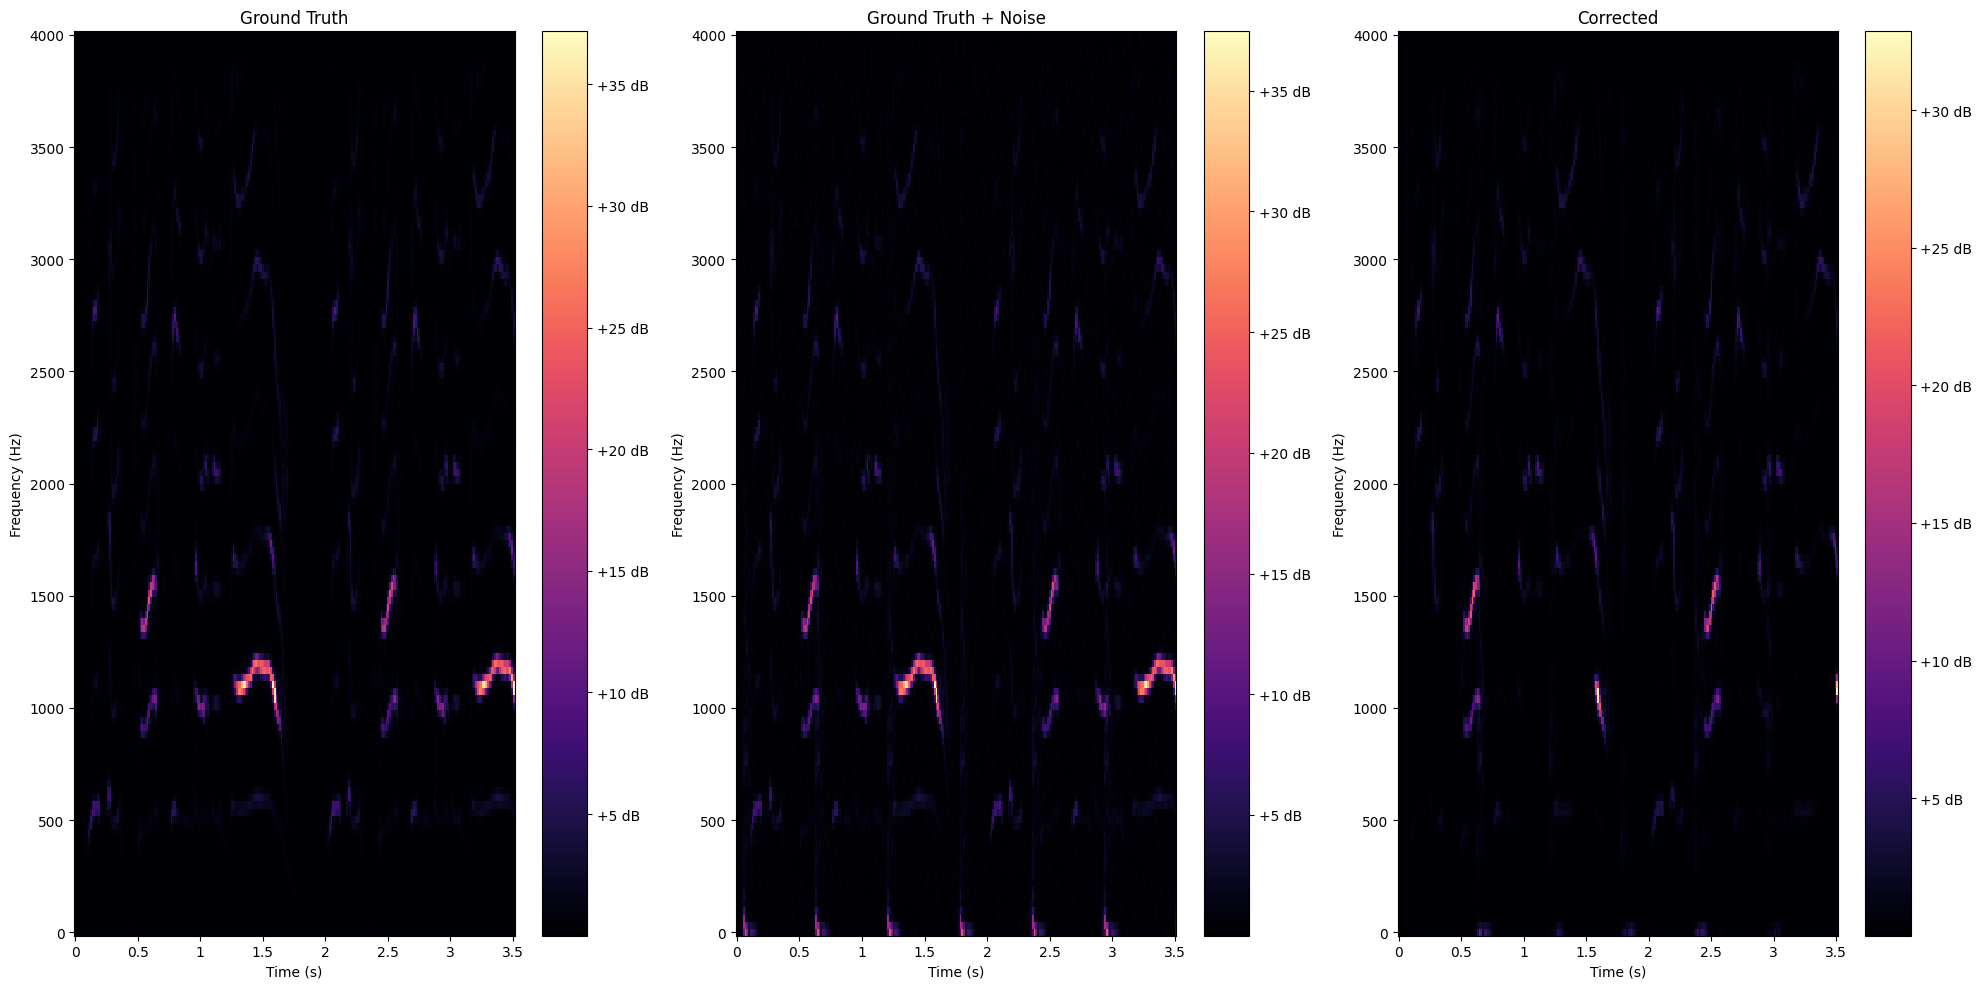

0

In [39]:
# Spectrogram visualization for best PESQ improvement
ind = np.where(pesq_diff == pesq_diff.max())[0][0]
fig, axes = plt.subplots(ncols=3, figsize=(20, 10))

# Calculate hop length in seconds
hop_length_sec = frame_step / sr

# Plot Clean Spectrogram
plt.subplot(1, 3, 1)
plt.title('Ground Truth')
# Transpose the spectrogram data so time is on the x-axis and frequency on the y-axis
# Capture the mappable object returned by specshow
mappable_clean = librosa.display.specshow(spec_clean_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[0])
# Pass the mappable object to colorbar
plt.colorbar(mappable_clean, format='%+2.0f dB', ax=axes[0]) # Optional: add colorbar with dB format
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Frequency (Hz)')


# Plot Corrupted Spectrogram
plt.subplot(1, 3, 2)
plt.title('Ground Truth + Noise')
# Transpose and plot corrupted spectrogram
# Capture the mappable object returned by specshow
mappable_corrupt = librosa.display.specshow(spec_corrupt_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[1])
# Pass the mappable object to colorbar
plt.colorbar(mappable_corrupt, format='%+2.0f dB', ax=axes[1]) # Optional: add colorbar with dB format
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')

# Plot Corrected Spectrogram
plt.subplot(1, 3, 3)
plt.title('Corrected')
# Transpose and plot corrected spectrogram
# Capture the mappable object returned by specshow
mappable_correct = librosa.display.specshow(spec_correct_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[2])
# Pass the mappable object to colorbar
plt.colorbar(mappable_correct, format='%+2.0f dB', ax=axes[2]) # Optional: add colorbar with dB format
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Frequency (Hz)')

# Adjust layout and save
plt.tight_layout()
fig.savefig(results_dir + '/best_spec.png', bbox_inches='tight')
plt.show() # Display the plot

# Spectrogram visualization for worst PESQ improvement
ind = np.where(pesq_diff == pesq_diff.min())[0][0]
fig, axes = plt.subplots(ncols=3, figsize=(20, 10))

# Plot Clean Spectrogram (Worst)
plt.subplot(1, 3, 1)
plt.title('Ground Truth')
# Transpose and plot clean spectrogram for worst case
# Capture the mappable object returned by specshow
mappable_clean_worst = librosa.display.specshow(spec_clean_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[0])
# Pass the mappable object to colorbar
plt.colorbar(mappable_clean_worst, format='%+2.0f dB', ax=axes[0]) # Optional: add colorbar with dB format
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Frequency (Hz)')

# Plot Corrupted Spectrogram (Worst)
plt.subplot(1, 3, 2)
plt.title('Ground Truth + Noise')
# Transpose and plot corrupted spectrogram for worst case
# Capture the mappable object returned by specshow
mappable_corrupt_worst = librosa.display.specshow(spec_corrupt_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[1])
# Pass the mappable object to colorbar
plt.colorbar(mappable_corrupt_worst, format='%+2.0f dB', ax=axes[1]) # Optional: add colorbar with dB format
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')

# Plot Corrected Spectrogram (Worst)
plt.subplot(1, 3, 3)
plt.title('Corrected')
# Transpose and plot corrected spectrogram for worst case
# Capture the mappable object returned by specshow
mappable_correct_worst = librosa.display.specshow(spec_correct_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[2])
# Pass the mappable object to colorbar
plt.colorbar(mappable_correct_worst, format='%+2.0f dB', ax=axes[2]) # Optional: add colorbar with dB format
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Frequency (Hz)')


# Adjust layout and save
plt.tight_layout()
fig.savefig(results_dir + '/worst_spec.png', bbox_inches='tight')
plt.show() # Display the plot


# Archiving results (keep this as is)
os.system(f'tar -cvzf train_val_results.tar.gz {results_dir}')